### Loading Dataset

In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(SummarizedExperiment))

saveDir <- "environment/real_datasets/GSE100505_EDL_MAST/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/DE"
load(file.path(saveDir, "tseConsUp.RData"))
load(file.path(saveDir, "bSwishCons_OL.RData"))
treeCons <- rowTree(tseConsUp)
l <- length(treeCons$tip)

#### Transcript level analysis

In [2]:
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/SRR_Acc_List.txt")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
samples <- metaData$RUN
files <- file.path(quantDir, samples, "quant.sf")
colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))
seMuscle <- tximeta::tximeta(colData)

importing quantifications

reading in files with read.delim (install 'readr' package for speed up)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Mus musculus - release M25 ]

loading existing TxDb created: 2023-02-17 18:26:37

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-02-17 18:26:39

fetching genome info for GENCODE



In [3]:
y <- fishpond::scaleInfReps(tseConsUp[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y, x="condition")

In [4]:
getLog2FC <- function(infRepsArray, condition, pc = 5) {
  dims <- dim(infRepsArray)
  cond1 <- condition == levels(condition)[1]
  cond2 <- condition == levels(condition)[2]
  diffs <- matrix(nrow = dims[1], ncol = dims[3])
  for (k in seq_len(dims[3])) {
    diffs[, k] <-
      log2(rowMeans(infRepsArray[, cond2, k]) + pc) - log2(rowMeans(infRepsArray[
        ,
        cond1, k
      ]) + pc)
  }

  # median over inferential replicates
  rowMedians(diffs)
}

In [5]:
yAll <- computeSizeFactors(tseConsUp)
yAll <- scaleInfReps(yAll)
yAll <- labelKeep(yAll)
set.seed(10)
yInn <- swish(yAll[(l+1):nrow(yAll),], x="condition")

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [6]:
infRepInds <- grep("infRep", assayNames(yAll))
infReps <- assays(yAll)[infRepInds]
infReps <- abind::abind(as.list(infReps), along = 3)
mcols(yAll)[["log2FC"]] <- getLog2FC(infReps, colData(yAll)[["condition"]])

In [7]:
pvals <- c(mcols(y)[["pvalue"]], mcols(yInn)[["pvalue"]])
adjust <- p.adjust(pvals, "BH")
mcols(yAll)[["qvalue"]] <- adjust

##### Differentially Expressed Transcripts

In [8]:
sapply(c(0.01,0.05,0.1), function(x) sum(mcols(y)[["qvalue"]] <= x, na.rm=T))
dTxps <- lapply(c(0.01,0.05,0.1), function(x) rownames(y)[which(mcols(y)[["qvalue"]] <= x)])
# save(dTxps, file=file.path(saveDir, "dTxps.RData"))

[1] 3149 6849 9592

##### Genes Mapping to those transcripts

In [9]:
mapDf <- rowData(seMuscle)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "gene_id"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 2685 5391 7121

#### Gene Level

In [10]:
gse <- summarizeToGene(seMuscle)
yg <- fishpond::scaleInfReps(gse)
yg <- labelKeep(yg)
set.seed(10)
yg <- swish(yg, x="condition")

loading existing TxDb created: 2023-02-17 18:26:37

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-02-21 05:37:24

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



##### Differentially expressed genes

In [11]:
dges <- lapply(c(0.01,0.05,0.1), function(x) rownames(yg)[which(mcols(yg)[["qvalue"]] <= x)])
sapply(dges, length)
# save(dges, file=file.path(saveDir, "dges.RData"))

[1] 2535 4494 5814

##### Genes that are considered differentially expressed in genes but dont contain a single differentially expressed transcript

In [12]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## Txps that are missing in differential transcripts mapping to genes
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Txps that are missing in differential transcripts mapping to genes                    
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

[1] 685 839 907

[1]  835 1736 2214

#### Terminus

In [26]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/SRR5758630/clusters.txt"
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseConsUp[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
yTerm <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yTerm)
yTerm <- labelKeep(yTerm)
set.seed(10)
yTerm <- swish(yTerm, x="condition")

#### TreeDE, with the total number of nodes, inner nodes and their height distribution

In [31]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
treeDE <- treeDEFDR_OL[["mIRV=0.4"]] ## renaming the treeDE variable
sapply(treeDE, length) ## number of differentially expressed nodes
sapply(treeDE, function(nodes) sum(nodes > l)) ## number of inner nodes
lapply(treeDE, function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights
lapply(detNodes[["treeClimbR"]], function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights for treeclimbR

[1]  3711  7693 10458

[1] 1189 2287 2958

[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2522  651  295  134   59   28    8    7    4    1    2 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   13 
5406 1285  555  252  107   46   20   11    4    1    3    3 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7500 1698  696  308  130   62   31   17    6    4    3    1    2 


[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2491  249   75   34   28   17    7    4    2    1    1 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
5259  485  192   57   56   36   13    7    3    3    1    1    1 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7449  580  231   76   61   39   15    9    4    3    1    1    1 


In [27]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["treeDEFDR_OL"]] <- lapply(treeDEFDR_OL[["mIRV=0.4"]], function(ta) ta)
detNodes[["treeClimbR"]] <- lapply(bSwish, function(sw) sw$output[sw$output$signal.node,][["node"]])
detNodes[["treeClimbRO"]] <- lapply(bSwish, function(sw) unlist(Descendants(treeCons,sw$output[sw$output$signal.node,][["node"]])))
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(yAggTermThrNS))
    })

In [29]:
treeDETxps <- rownames(tseConsUp)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[3]]))]
treeClimbTxps <- rownames(tseConsUp)[unlist(Descendants(treeCons, detNodes[["treeClimbR"]][[3]]))]

dN <- detNodes[["term"]][[3]]

termTxps <- c(rownames(yAggTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

In [28]:
length(detNodes[["term"]][[3]])

[1] 8981

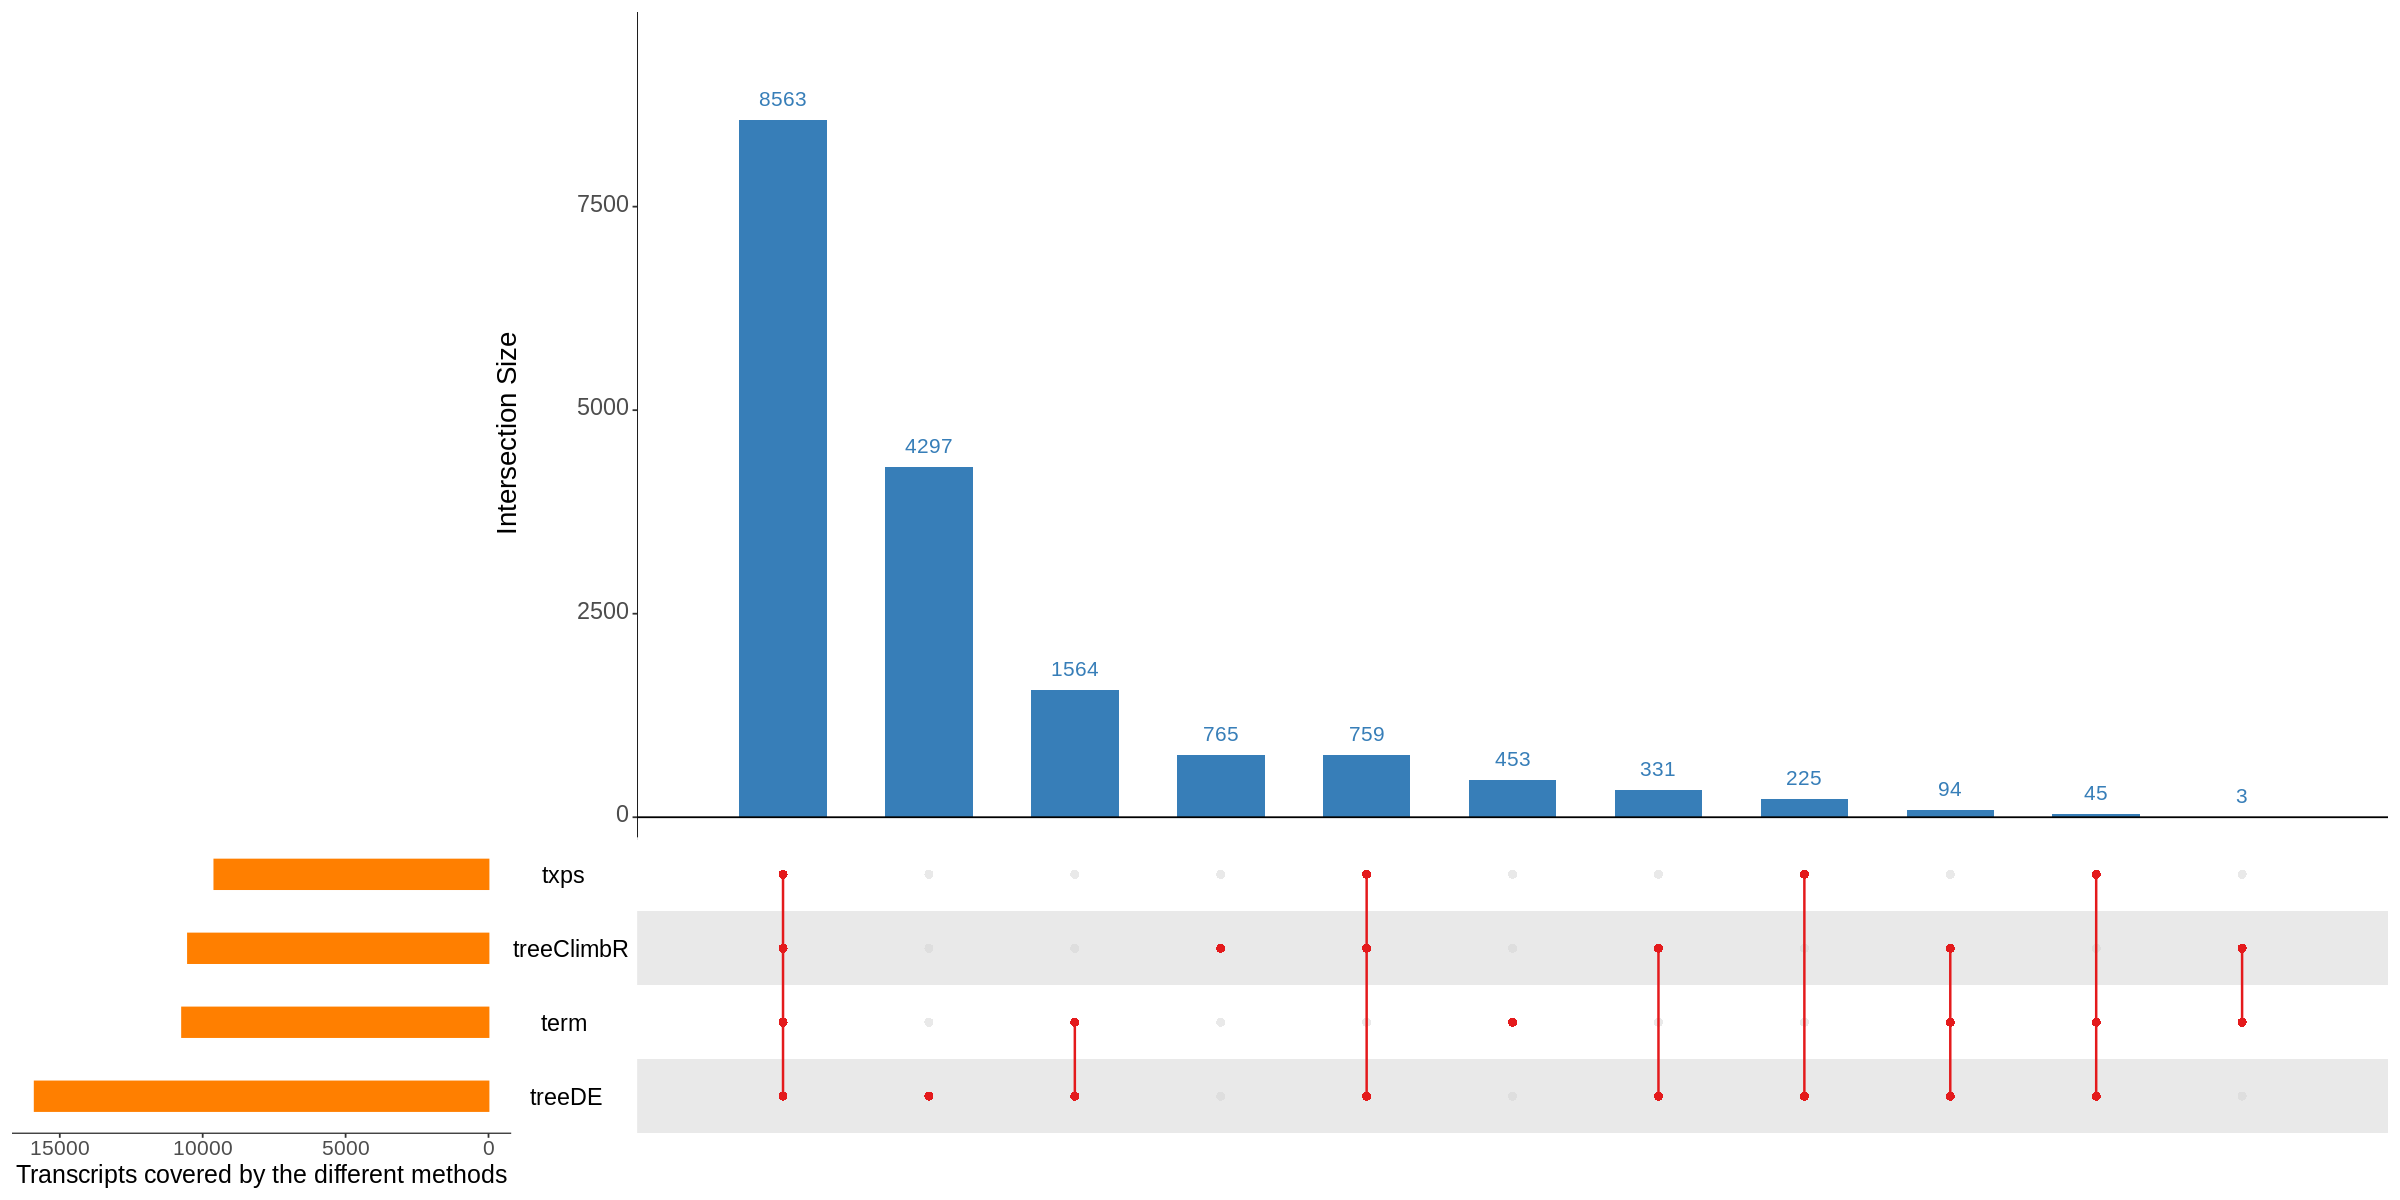

In [30]:
options(repr.plot.width=20, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(txps = dTxps[[3]], 
                 treeDE = treeDETxps, 
                 treeClimbR = treeClimbTxps, 
                 term = termTxps)
upsetData <- fromList(txpMethods)
size <- 2
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by the different methods",
     shade.alpha = 0.7, 
     text.scale = c(size, size, 1.8, 1.8, size, size)
)

##### Genes mapping to the treeClimbR nodes and their number

In [16]:
genesTCR <- lapply(detNodes[["treeClimbR"]], function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTCR, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTCR, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 2731 5423 7117

[[1]]

   1    2    3    4    5    6    8 
2872   25    4    4    2    1    1 

[[2]]

   1    2    3    4    5    6    8   11 
6046   50    7    4    2    2    2    1 

[[3]]

   1    2    3    4    5    6    7    8   11 
8390   57   10    4    2    2    1    3    1 


##### Genes mapping to the treeDE nodes and their number

In [32]:
genesTreeDE <- lapply(treeDE, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTreeDE, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTreeDE, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3255 6220 8010

[[1]]

   1    2    3    5 
3672   33    5    1 

[[2]]

   1    2    3    4 
7625   56    8    4 

[[3]]

    1     2     3     4     7     9 
10369    73     9     4     1     2 


In [36]:
sum(sapply(genesTreeDE[[1]],length))

[1] 3758

#### Gene Families for these genes

In [17]:
genes <- unlist(lapply(strsplit(unlist(genesTreeDE[[3]]), ".", fixed=T), function(x) x[[1]]))
names(genes) <- unlist(genesTreeDE[[3]])

In [18]:
# iN <- which(sapply(genesTreeDE[[3]],length)>=2)
# genesTreeDE[[3]][[iN[2]]]
library(biomaRt)
ensembl <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
selected_attributes <- c("ensembl_gene_id", "external_gene_name")
gene_info <- getBM(attributes = selected_attributes, filters = "ensembl_gene_id", mart = ensembl, values = unlist(genes))
head(gene_info)

,ensembl_gene_id,external_gene_name
,<chr>,<chr>
1,ENSMUSG00000000001,Gnai3
2,ENSMUSG00000000093,Tbx2
3,ENSMUSG00000000127,Fer
4,ENSMUSG00000000149,Gna12
5,ENSMUSG00000000171,Sdhd
6,ENSMUSG00000000247,Lhx2


In [20]:
gs <- genesTreeDE[[3]][sapply(genesTreeDE[[3]],length)>=2]

In [18]:
length(gs)
for(i in seq_along(gs)) {
        print(gene_info[match(genes[gs[[i]]],gene_info$ensembl_gene_id),2])
}

[1] 89

[1] "Bcl2a1d" "Bcl2a1a"
[1] "Rps7"     "Rps7-ps3"
[1] "Gm13237" "Gm4739" 
[1] "Gm7334" "Btg3"  
[1] "Nat8f3" "Nat8f7"
[1] "Ugt1a10" "Ugt1a9"  "Ugt1a8"  "Ugt1a5"  "Ugt1a2"  "Ugt1a1"  "Ugt1a6b"
[8] "Ugt1a6a" "Ugt1a7c"
[1] "Zc3h3"  "Gm7353"
[1] "Rpl3"     "Rpl3-ps1"
[1] "Hacl1"   "Gm49387"
[1] "Gvin1" "Gvin2"
[1] "Gm14176" "Gm5931" 
[1] "Bnip3l-ps" "Bnip3l"   
[1] "Rmi1"    "Gm20775"
[1] "Meg3"    "Gm27000"
[1] "Nnt" "Nnt"
[1] "Tpt1"     "Tpt1-ps3"
[1] "Pcdhgb6" "Pcdhga4"
[1] "Pcdhga12" "Pcdhgb7" 
[1] "Pcdhgb8" "Pcdhga2"
[1] "Ube2s"  "Gm2296"
[1] "Xntrpc" "Trpc2" 
[1] "Zfp82"   "Gm26920"
[1] "Gm12416" "Gm5944"  "Gm3534"  "Gm2308"  "Gm4217"  "Gm7251"  "Gm4518" 
[8] "Gm10290" "Gm8349" 
[1] "Gm8055"  "Gm11953"
[1] "Gm16534" "Fam78a" 
[1] "Prn"  "Prnd"
[1] "Hdhd2" NA     
[1] "Pakap" "Pakap"
[1] "Hmgb1"   "Gm21596"
[1] "Flad1" "Lenep"
[1] "Rpl36a"     "Rpl36a-ps1" "Rpl36a-ps2"
[1] "Arfip1"  "Gm37240"
[1] "Glcci1"  "Gm45062"
[1] "Rsph3a" "Rsph3b"
[1] "Nap1l1" "Gm4204"
[1] "Mbtps2" "Yy2"   
[1]

#### Genes that map only to treeDE but are neither DE or covered by differential transcripts

In [21]:
innerNodesUniqueGenes <- lapply(seq_along(genesTreeDE), function(i) setdiff(unlist(genesTreeDE[[i]]), union(dges[[i]], txpGenes[[i]])))
head(innerNodesUniqueGenes[[2]]) 
sapply(innerNodesUniqueGenes, length)

unGenesSNode <- lapply(seq_along(innerNodesUniqueGenes), function(i) {
gNodes <- innerNodesUniqueGenes[[i]]
gNodes[sapply(gNodes, function(gene) {
sum(sapply(genesTreeDE[[i]], function(g) sum(gene %in% g) > 0 & length(g)>1)) == 0 ##gene maps unique to a single node
})]
})
sapply(unGenesSNode, length) ### Nodes that map to a single gene

[1] 264 405 428

[1] 207 316 307

Such inner nodes can be possible DTUs. We thus extract the treeDE nodes to which these genes map to and try to see if there are multiple such tree DE nodes that map to same gene.Looking at the 0.1 threshold change, we find only 1 gene for which a dtu on the inner nodes is observed.

For the remaining that have map to inner node, infRV decreases compared to their children though the logFC is lower compared to children. logFC though definitely decreases at gene.

In [39]:
qval <- 0.1
i <- 3
gN <- innerNodesUniqueGenes[[i]]
length(gN)

# extracting genes unique to treeDE and have logFC > 0.5 or have atleast two sig nodes
twoNodes <- list()
lfcNodes <- c()
j <- 1
for(g in gN) {
    iid <- which(sapply(genesTreeDE[[i]], function(genes) sum(g %in%  genes) > 0))
    if(length(iid) > 1) {
        twoNodes[[j]] <- iid
        j <- j + 1
    }
    else if(length(which(abs(mcols(yAll)[treeDE[[i]][iid],"log2FC"]) > 0.5)) > 0) {
        lfcNodes <- c(lfcNodes, iid)
    }
}
length(twoNodes)
length(lfcNodes)

[1] 428

[1] 4

[1] 243

##### DTU

In [49]:
##Follow up analysis
## (1,2) map to more than 1 gene
## 4,5,6 shows no dtu
twoNodes
for(j in seq_along(twoNodes)) {
    gs <- genesTreeDE[[i]][[twoNodes[[j]][1]]]
    genesTreeDE[[i]][[twoNodes[[j]][2]]]

    print("Gene Level")
    print(mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")])

    print("TreeDE Node 1")
    print(cbind(mcols(yAll)[treeDE[[i]][twoNodes[[j]][1]],], qval = adjust[treeDE[[i]][twoNodes[[j]][[1]]]]))
#     print("Transcripts mapping TreeDE Node 1")
#     print(cbind(mcols(yAll)[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][1]])),], 
#           qval = adjust[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][1]]))]))

    print("TreeDE Node 2")
    print(cbind(mcols(yAll)[treeDE[[i]][twoNodes[[j]][2]],],
         qval = adjust[treeDE[[i]][twoNodes[[j]][[2]]]]))
#     print("Transcripts mapping TreeDE Node 2")
#     print(cbind(mcols(yAll)[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][2]])),], 
#           qval = adjust[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][2]]))]))
    
    print("new")
}


[[1]]
[1] 6391 6392

[[2]]
[1] 6540 6543

[[3]]
[1] 8752 8753

[[4]]
[1] 9985 9986

[1] "Gene Level"
DataFrame with 3 rows and 3 columns
                      log10mean    log2FC    qvalue
                      <numeric> <numeric> <numeric>
ENSMUSG00000059005.13   3.75342  0.582774 0.0239884
ENSMUSG00000069014.4    2.43071  0.465375 0.7014601
ENSMUSG00000081205.4    1.12337        NA        NA
[1] "TreeDE Node 1"
DataFrame with 1 row and 6 columns
           meanInfRV log10mean      keep    log2FC    qvalue      qval
           <numeric> <numeric> <logical> <numeric> <numeric> <numeric>
Node142495   1.00929   3.42829      TRUE  0.554751 0.0274336 0.0274336
[1] "TreeDE Node 2"
DataFrame with 1 row and 6 columns
           meanInfRV log10mean      keep    log2FC     qvalue       qval
           <numeric> <numeric> <logical> <numeric>  <numeric>  <numeric>
Node142499  0.922514   3.47419      TRUE  0.606193 0.00147547 0.00147547
[1] "new"
[1] "Gene Level"
DataFrame with 2 rows and 3 columns
                     log10mean    log2FC     qvalue
                     <numeric>

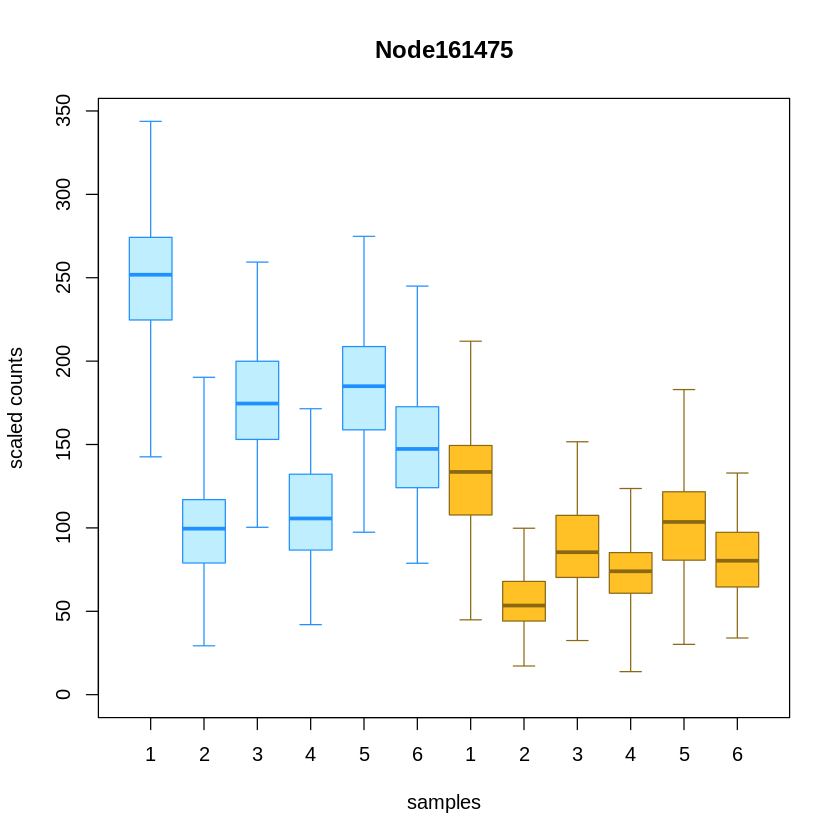

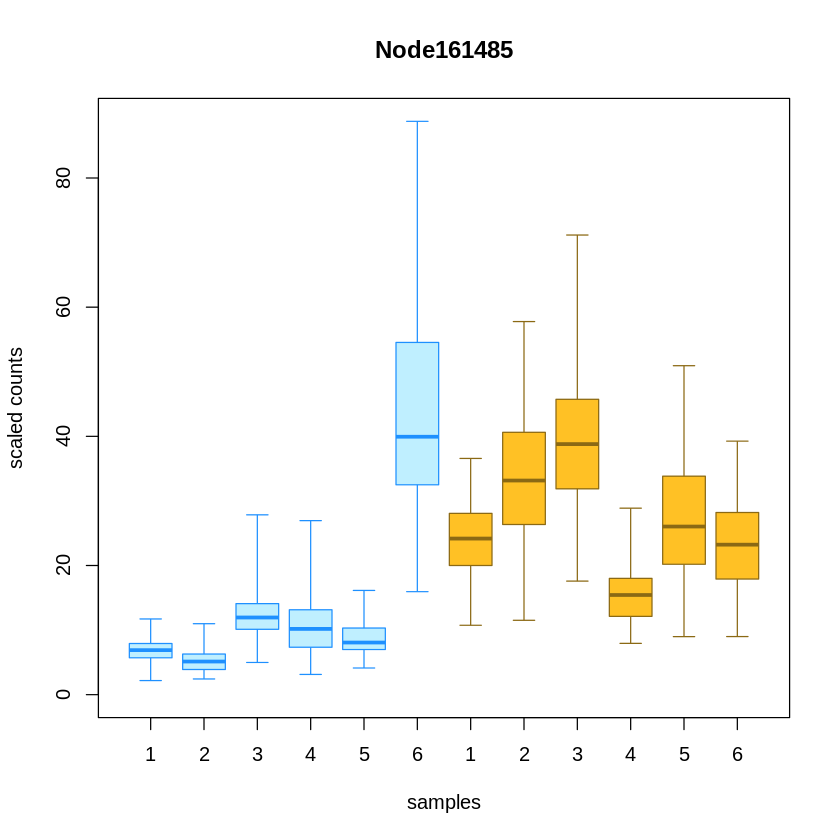

In [51]:
j <- 3
plotInfReps(y=yAll, x = "condition", idx = treeDE[[i]][twoNodes[[j]][1]])
plotInfReps(y=yAll, x = "condition", idx = treeDE[[i]][twoNodes[[j]][2]])

##### Other example of the above genes that however show no dtu

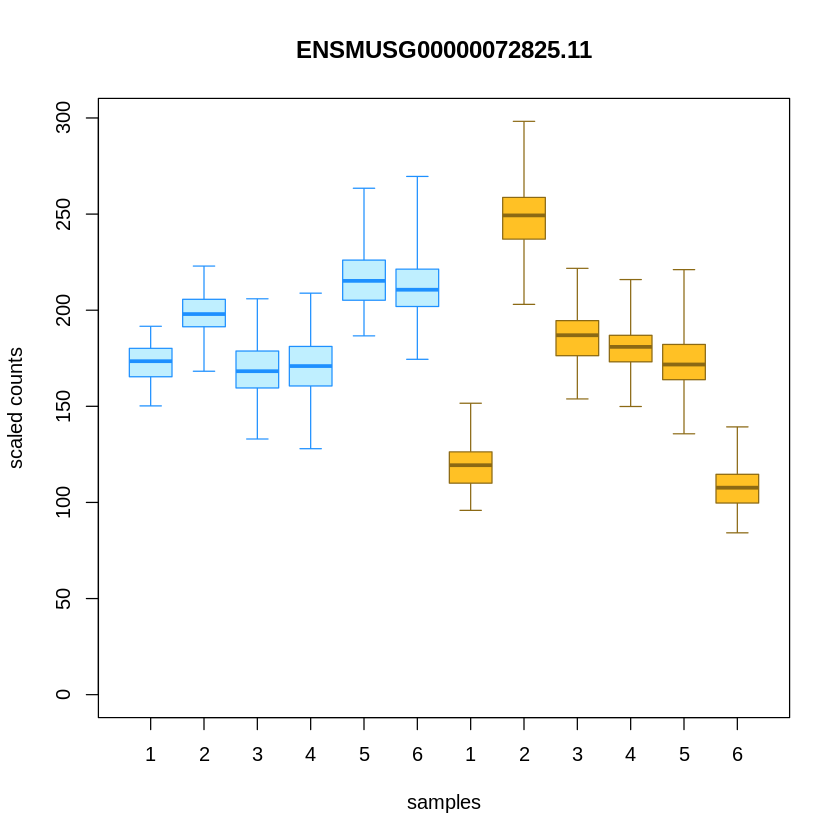

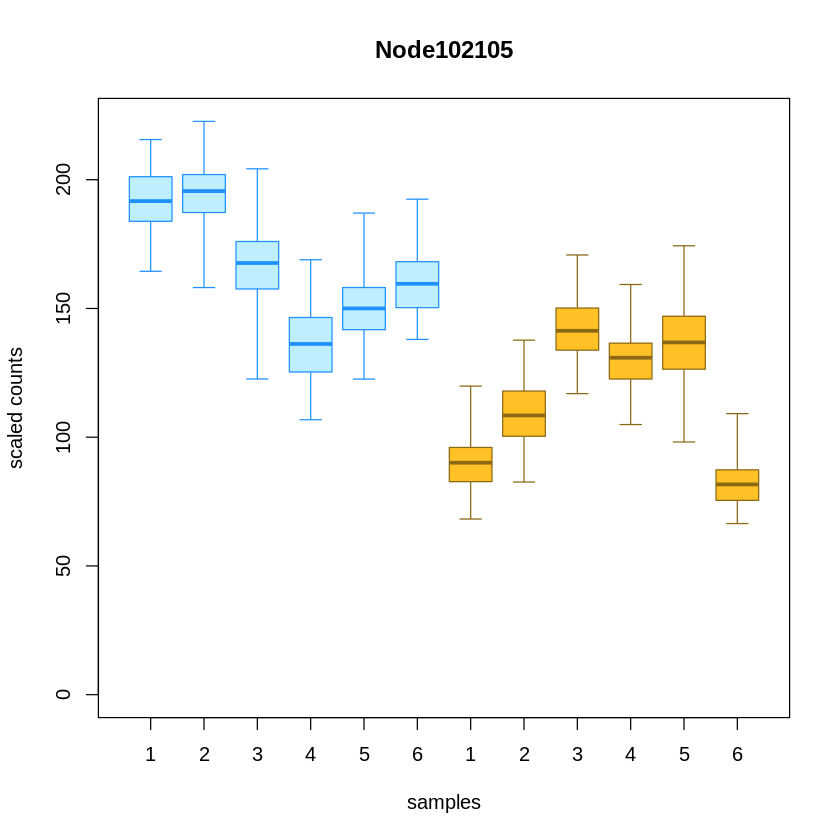

In [86]:
### What is causing this expression to fall
### tcr how to solve it
j <- c(5,9)
plotInfReps(y=yg, x = "condition", idx = genesTreeDE[[i]][[lfcNodes[j]]])
plotInfReps(y=yAll, x = "condition", idx = treeDE[[i]][lfcNodes[j]])
# plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[i]][lfcNodes[j]]))[1])
# plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[i]][lfcNodes[j]]))[2])
# plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[i]][lfcNodes[j]]))[3])

In [82]:
j <- 5
mcols(yg)[genesTreeDE[[i]][[lfcNodes[j]]],]
mcols(yAll)[treeDE[[i]][lfcNodes[[j]]],]

DataFrame with 1 row and 9 columns
                                    gene_id
                                <character>
ENSMUSG00000028651.12 ENSMUSG00000028651.12
                                                                                  tx_ids
                                                                         <CharacterList>
ENSMUSG00000028651.12 ENSMUST00000030404.4,ENSMUST00000136466.7,ENSMUST00000126558.7,...
                      log10mean      keep      stat    log2FC    pvalue
                      <numeric> <logical> <numeric> <numeric> <numeric>
ENSMUSG00000028651.12   2.42924      TRUE     -6.93 -0.118778  0.244934
                         locfdr    qvalue
                      <numeric> <numeric>
ENSMUSG00000028651.12         1  0.384265

DataFrame with 1 row and 5 columns
          meanInfRV log10mean      keep    log2FC    qvalue
          <numeric> <numeric> <logical> <numeric> <numeric>
Node99551  0.924971    2.0666      TRUE -0.725937 0.0339221

In [60]:
genesTreeDE[[i]][[lfcNodes[j]]]

[1] "ENSMUSG00000056708.5"

In [23]:
## A lowering of the LFC but also along with a substantial decrease in infRV
## Some of these nodes map to multiple genes some of which are DEs
head(order(mcols(yAll)[treeDE[[2]][lfcNodes],"log10mean"], decreasing=T), 30)
j <- 118
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")]
mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]
print("j")

j <- 25
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
mcols(yg)[gs,c("log10mean", "log2FC")]
mcols(yAll)[cbind(treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")),]
mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]
print("j")
# j <- 142
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# mcols(yg)[gs,c("log10mean", "log2FC")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")]
# mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]

# j <- 143
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]

[1] 118  25 142 143  65 188  50   5 158  61  21  69 135 222 194  98  48 213  64
[20] 147 113 208 105  31  67  19  91 125 156 116

[1] "ENSMUSG00000038717.8"


DataFrame with 1 row and 3 columns
                     log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric>
ENSMUSG00000038717.8   3.88265  0.200366  0.614476

DataFrame with 1 row and 3 columns
           meanInfRV log10mean    log2FC
           <numeric> <numeric> <numeric>
Node135025  0.878695   3.76715 -0.525694

DataFrame with 2 rows and 3 columns
                     meanInfRV log10mean    log2FC
                     <numeric> <numeric> <numeric>
ENSMUST00000213999.1   1.82022   3.59143 -0.571328
ENSMUST00000043675.8   4.11910   3.30611 -0.457364

[1] "j"


DataFrame with 1 row and 2 columns
                      log10mean    log2FC
                      <numeric> <numeric>
ENSMUSG00000022565.15    4.0153  -1.38563

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
"subscript is an array, passing it thru as.vector() first"


DataFrame with 6 rows and 5 columns
     meanInfRV log10mean      keep    log2FC    qvalue
     <numeric> <numeric> <logical> <numeric> <numeric>
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA

DataFrame with 3 rows and 3 columns
                      meanInfRV log10mean    log2FC
                      <numeric> <numeric> <numeric>
ENSMUST00000074834.11   258.479   3.09477  -1.42773
ENSMUST00000169108.7    324.507   3.17899  -1.25254
ENSMUST00000169438.7    361.319   2.66116  -1.04827

[1] "j"


#### Genes belonging to treeDE nodes that intersect with differentially expressed genes but are not covered by transcripts.'
We see many such genes that contain differential nodes but no differentially expressed transcripts. The magnitude of logFC in most cases though decreases from trancript to gene.

In [24]:
genesNodeCommonDGE <- lapply(seq_along(diffGenes), function(i) unlist(genesTreeDE[[i]])[unlist(genesTreeDE[[i]]) %in% diffGenes[[i]]]) ## Number of genes mapping to inner nodes that also map to dges but not dtes
treeDECommonInds <- lapply(seq_along(genesNodeCommonDGE), function(i) {
    sapply(genesNodeCommonDGE[[i]], function(genes) {
        sapply(genes, function(gene) {
            which(sapply(genesTreeDE[[i]], function(gs) sum(gene %in% gs) > 0))
        })
    })
})
sapply(genesNodeCommonDGE, length)

[1] 309 428 465

In [19]:
order(mcols(yg)[genesNodeCommonDGE[[3]], "qvalue"])

[1]  58  73 105 308 317 335 356  47  95 244 262 302 252 131  77 216 451  49
 [19] 418 312 150  21 385  14 322  79 153 398 352 353  81  16 363 184 453 109
 [37]  38 258 180 367 195 151 344 383  45 280 207 174 217  54 300 187 139 243
 [55] 407  56 120 293 371  37 147 166 121 145  48 351  46 326 438 404  87 193
 [73] 340  70 192 276 365 112 212 101 164 223 325  76 391 437 463 115 430 431
 [91] 458 310 205 226 227 369 465 170 288 263 316 440 196 274 259 134 289 386
[109] 146 191  62 158 361  18 442 167 116 343 254 305 327 311  31 188 388 450
[127] 106 315 370   2 396 178 454 455 272 333 338 304  91 211 382 171   9  36
[145] 230 358 152 360 118 269  53 144 256 266 111 119 203 110 189 183 224 324
[163] 157 161 402 186  67 341 291 387 321 218 448 213 427 393 350 136 210 460
[181] 175 176  60  69 368 397 329 348 245   1  80  23 323  22 281 374 394 435
[199]  32 432 389 199 357  17 347 181 221 222 250  72 135 208 246 143  75 261
[217] 414 318 346 419  42 354 214 275 270 434 128 295 399 306 141 299 381  93
[235]  15  12 155 461 225  90  64 247 334 464   3 264  24 373 413  34 163 100
[253]  85 248  26 201 457 277 133 412 283 339 424  66 433 126  97 198 384 409
[271] 462  94 114  19 232  29 190 307 241 282   8 378 138  63 294  44  98 422
[289] 420 162 122 336 362  39 271 401   4 132 426 446   5 330 287 408  13 104
[307]  89  84 169  74 428 177 107 267 349  10  41 124 292 301 137 235 236 303
[325] 332 257 372  20 331 156  71  88 395 172 200 284 273 411  86 234 443 148
[343] 405 377 416 375 149 249  40 320  68  82 309 160 297 285 129  57 439   6
[361] 406 290 229 239 429 441 286  30  61 392  59 130 359 400 452 103  25  92
[379] 447 240 436 127 355  55 279 403 444 237 425 197 220 182  99 390 366 296
[397] 255 456 159  43 179 314  35  65 206 319  27 142 233 251 265 449 337  28
[415] 231 415 125 173 123 278 215 364 117 165  11 345  52 238 202 410  96 228
[433] 204 209 328 253 421  33 376 219 298 423 185 417  78 242  51 459  50 102
[451]   7 168 194  83 260 154 268 113 140 313 108 342 379 380 445

In [26]:
i <- 3
#121,263,269,292,301
for(j in c(73,308,317,335,356,47,95,244,262)) {
    g <- genesNodeCommonDGE[[i]][j]
    txps <- unlist(mcols(yg)[g,2])
    print(length(txps))
    print(mcols(yg)[g,c("log10mean", "log2FC", "qvalue")])
    print(mcols(y)[txps[which.min(abs(mcols(y)[txps, 'qvalue']))],c("log10mean", "log2FC", "qvalue")])
    print(mcols(yAll)[treeDE[[i]][treeDECommonInds[[i]][[j]]],c("meanInfRV", "log10mean", "log2FC", "qvalue")])
    print(mcols(y)[Descendants(treeCons,treeDE[[i]][treeDECommonInds[[i]][[j]]])[[1]],c("meanInfRV", "log10mean", "log2FC", "qvalue")])
}


[1] 5
DataFrame with 1 row and 3 columns
                      log10mean    log2FC      qvalue
                      <numeric> <numeric>   <numeric>
ENSMUSG00000070509.15   2.56105   -1.0168 1.08696e-05
DataFrame with 1 row and 3 columns
                      log10mean    log2FC    qvalue
                      <numeric> <numeric> <numeric>
ENSMUST00000094312.11   2.06927  -1.12426  0.105674
DataFrame with 1 row and 4 columns
           meanInfRV log10mean    log2FC      qvalue
           <numeric> <numeric> <numeric>   <numeric>
Node113356 0.0404829   2.52999  -1.02839 4.24828e-06
DataFrame with 3 rows and 4 columns
                      meanInfRV log10mean    log2FC    qvalue
                      <numeric> <numeric> <numeric> <numeric>
ENSMUST00000119206.2    26.8956   1.99132 -1.327839  0.165033
ENSMUST00000094312.11   31.3990   2.06927 -1.124258  0.105674
ENSMUST00000139780.2    28.1462   2.09908 -0.638777  0.713679
[1] 3
DataFrame with 1 row and 3 columns
                      log

https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000026883;r=2:35448278-35621006
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000057315;mr=5:102861682-103051275;r=5:102629257-103045803;t=ENSMUST00000073302
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000070509;r=7:73025257-73069647
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000019699;r=1:176847639-177085769
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000038481;r=10:40215560-40359814
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000022553;r=15:76235494-76238580
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000021143;r=12:112978128-113038021
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000038807;r=11:74274182-74501741

In [5]:
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.01, na.rm=T)
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.05, na.rm=T)
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.1, na.rm=T)

sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.01, na.rm=T)
sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.05, na.rm=T)
sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.1, na.rm=T)

[1] 3384

[1] 6784

[1] 9641

[1] 869

[1] 5631

[1] 8348

#### Plot Transcripts from
https://nullranges.github.io/tidy-ranges-tutorial/isoform-analysis.html

In [29]:
library(org.Mm.eg.db)
library(TxDb.Mmusculus.UCSC.mm10.knownGene) ## this one corresponds to the version we need
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("ggplotify"))
suppressPackageStartupMessages(library("ggplot2"))

txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
txpMouse <- transcripts(txdb)


txpMouse <- txpMouse %>%
  mutate(tx_id = as.character(tx_id))

txpMouse <- txpMouse %>%
  mutate(gene_id = mapIds(
           txdb, keys=tx_id,
           column="GENEID", keytype="TXID")
         ) %>%
  filter(!is.na(gene_id))
head(txpMouse)
txpMouse <- txpMouse %>%
  mutate(ensID = mapIds(
           org.Mm.eg.db, keys=gene_id,
           column="ENSEMBL", keytype="ENTREZID")
         ) %>%
  filter(!is.na(ensID))
length(txpMouse)
txpMouse <- txpMouse %>%
                filter(tx_name %in% intersect(treeCons$tip, mcols(txpMouse)[["tx_name"]]))
head(txpMouse)



'select()' returned 1:1 mapping between keys and columns



GRanges object with 6 ranges and 3 metadata columns:
      seqnames          ranges strand |       tx_id               tx_name
         <Rle>       <IRanges>  <Rle> | <character>           <character>
  [1]     chr1 4807788-4848410      + |          14  ENSMUST00000134384.7
  [2]     chr1 4807823-4846739      + |          15 ENSMUST00000027036.10
  [3]     chr1 4807830-4841286      + |          16  ENSMUST00000150971.7
  [4]     chr1 4807892-4886770      + |          17  ENSMUST00000155020.1
  [5]     chr1 4807896-4845174      + |          18  ENSMUST00000119612.8
  [6]     chr1 4807898-4840969      + |          19  ENSMUST00000137887.7
          gene_id
      <character>
  [1]       18777
  [2]       18777
  [3]       18777
  [4]       18777
  [5]       18777
  [6]       18777
  -------
  seqinfo: 66 sequences (1 circular) from mm10 genome

'select()' returned 1:many mapping between keys and columns



[1] 101405

GRanges object with 6 ranges and 4 metadata columns:
      seqnames          ranges strand |       tx_id               tx_name
         <Rle>       <IRanges>  <Rle> | <character>           <character>
  [1]     chr1 4807788-4848410      + |          14  ENSMUST00000134384.7
  [2]     chr1 4807823-4846739      + |          15 ENSMUST00000027036.10
  [3]     chr1 4807830-4841286      + |          16  ENSMUST00000150971.7
  [4]     chr1 4807892-4886770      + |          17  ENSMUST00000155020.1
  [5]     chr1 4807896-4845174      + |          18  ENSMUST00000119612.8
  [6]     chr1 4807898-4840969      + |          19  ENSMUST00000137887.7
          gene_id              ensID
      <character>        <character>
  [1]       18777 ENSMUSG00000025903
  [2]       18777 ENSMUSG00000025903
  [3]       18777 ENSMUSG00000025903
  [4]       18777 ENSMUSG00000025903
  [5]       18777 ENSMUSG00000025903
  [6]       18777 ENSMUSG00000025903
  -------
  seqinfo: 66 sequences (1 circular) from mm10 ge

In [30]:
### print(columns(txdb))
print(columns(org.Mm.eg.db))

 [1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MGI"         
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIPROT"     


In [31]:
library(tibble)
tab <- txpMouse %>%
  group_by(gene_id) %>%
  summarize(ntxp = n_distinct(tx_id)) %>%
  as_tibble()

In [32]:
tab_longer <- dplyr::left_join(tibble(gene_id=txpMouse$gene_id), tab)
txpMouse <- txpMouse %>%
  mutate(ntxp = tab_longer$ntxp)

Joining with `by = join_by(gene_id)`


In [33]:
ebt <- exonsBy(txdb, by="tx")
ebt <- ebt[txpMouse$tx_id]
exons <- unlist(ebt) %>%
  select(exon_id, exon_rank) %>%
  mutate(tx_id = rep(names(ebt), lengths(ebt)))

In [34]:
genesMouse <- genes(txdb)
genesMouse <- genesMouse %>%
  mutate(ensID = mapIds(org.Mm.eg.db, 
                            gene_id, "ENSEMBL", "ENTREZID")) %>% 
    filter(!is.na(ensID))
genesMouse

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

'select()' returned 1:many mapping between keys and columns



GRanges object with 24069 ranges and 2 metadata columns:
            seqnames              ranges strand |     gene_id
               <Rle>           <IRanges>  <Rle> | <character>
  100009600     chr9   21062393-21073096      - |   100009600
  100009609     chr7   84935565-84964115      - |   100009609
  100009614    chr10   77711457-77712009      + |   100009614
     100012     chr4 144157557-144162663      - |      100012
     100017     chr4 134741554-134768024      - |      100017
        ...      ...                 ...    ... .         ...
      99889     chr3   84496093-85887516      - |       99889
      99890     chr3 110246109-110250998      - |       99890
      99899     chr3 151730922-151749960      - |       99899
      99929     chr3   65528410-65555518      + |       99929
      99982     chr4 136550540-136602723      - |       99982
                         ensID
                   <character>
  100009600 ENSMUSG00000079681
  100009609 ENSMUSG00000066372
  100009614 E

In [35]:
txp_data <- txpMouse %>%
  select(tx_id, ensID, ntxp, .drop_ranges=TRUE) %>%
  as_tibble()
ids <- dplyr::left_join(tibble(tx_id = exons$tx_id),
                        txp_data, by="tx_id")
# ids
all.equal(exons$tx_id, ids$tx_id)
mcols(exons) <- cbind(mcols(exons), ids %>% select(-tx_id))


exon_parts <- exons %>%
  group_by(ensID)

[1] TRUE

In [36]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 308
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)

gs[1]
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g


txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000038569.7" "ENSMUST00000108109.7" "ENSMUST00000108107.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000037211.12"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr3,37639947,37644598,4652,+,24063,ENSMUSG00000037211


[1] 2

[1] TRUE

In [37]:
options(repr.plot.width=14, repr.plot.height=9)
of=20.5
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 50) +
    geom_tiplab(size=5, hjust=-0.1) +
    geom_point2(aes(subset=(node==4), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==2), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = 4, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = 2, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



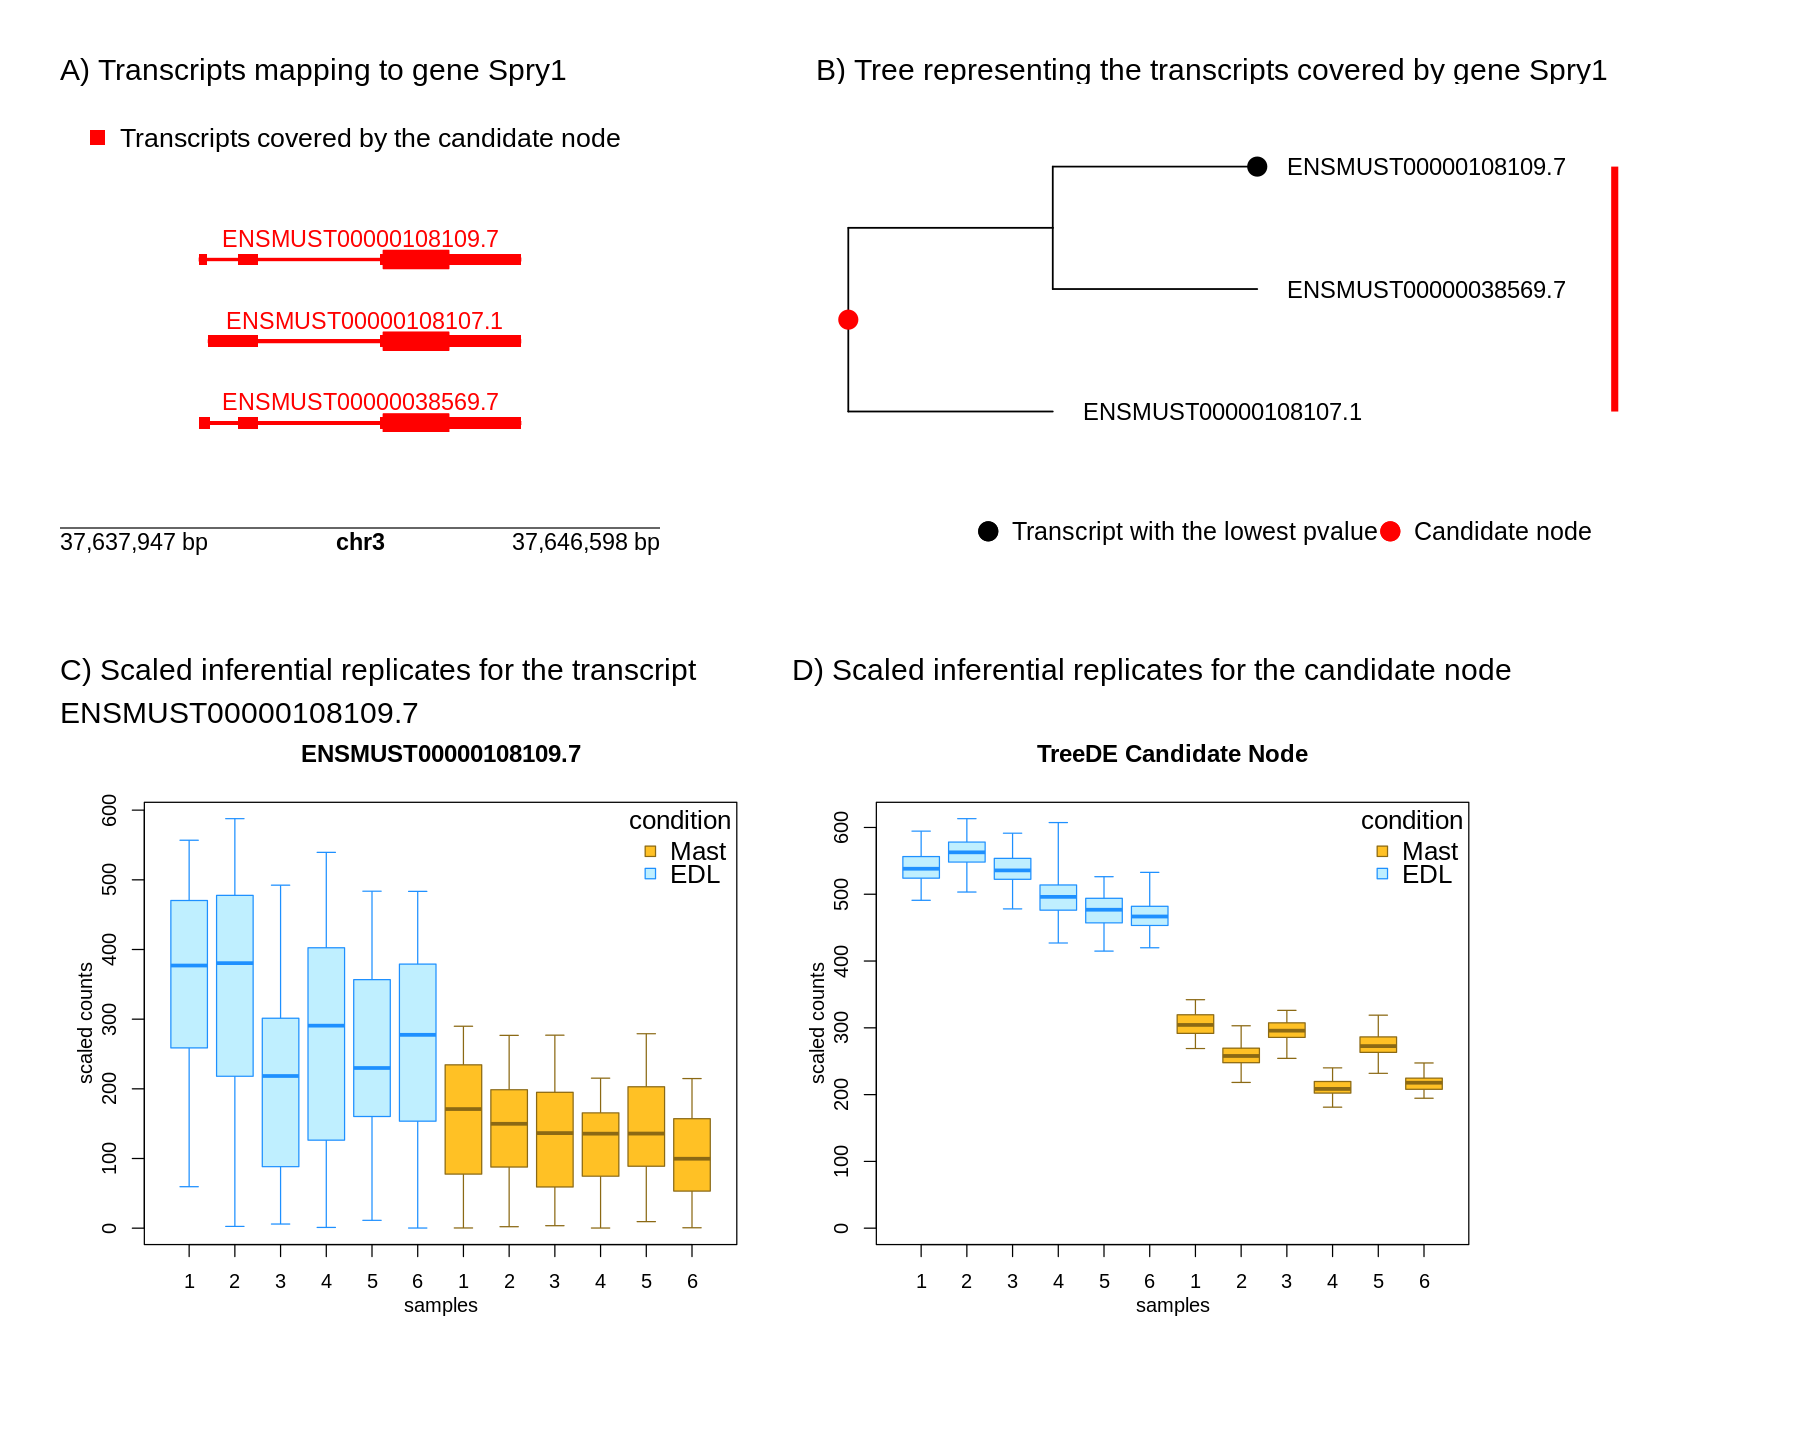

In [38]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 11.4, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]]+2000,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

# hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
#                      color=c(rep("red", length(tx_to_show)), 
#                              rep("black", length(setdiff(treeSub$tip, tx_to_show)))))

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node"),
    fill = c("red"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Spry1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 3.3, width = 5, height = 6, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.1, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Spry1", 
         x = 6.8, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.6, y = 0.4, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000108109.7", 
         x = 0.5, y = 5.2, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 5.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 6.6, y = 5.2, params = parText)

plotGG(
    plot = pInn,
    x = 6.6, y = 5.8, width = 6, height=5
)


In [93]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 335
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
anc <- 155607
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])
gTxps

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
sum(gTxps %in% treeCons$tip)

gs[1]
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000160853.7"  "ENSMUST00000023212.14" "ENSMUST00000161527.7" 
[4] "ENSMUST00000160172.7"

[1] TRUE

ENSMUSG00000022553.16   ENSMUSG00000022553.16   ENSMUSG00000022553.16 
 "ENSMUST00000161527.7"  "ENSMUST00000160853.7" "ENSMUST00000023212.14" 
  ENSMUSG00000022553.16   ENSMUSG00000022553.16   ENSMUSG00000022553.16 
 "ENSMUST00000162871.1"  "ENSMUST00000160857.7"  "ENSMUST00000160172.7" 
  ENSMUSG00000022553.16   ENSMUSG00000022553.16   ENSMUSG00000022553.16 
 "ENSMUST00000160097.1"  "ENSMUST00000161786.1"  "ENSMUST00000160914.2" 
  ENSMUSG00000022553.16   ENSMUSG00000022553.16   ENSMUSG00000022553.16 
 "ENSMUST00000160069.1"  "ENSMUST00000162865.7"  "ENSMUST00000161391.1" 
  ENSMUSG00000022553.16   ENSMUSG00000022553.16 
 "ENSMUST00000160875.1"  "ENSMUST00000161072.1"

[1] TRUE

[1] TRUE

[1] 14

[1] "ENSMUSG00000022553.16"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr15,76351294,76354380,3087,+,68877,ENSMUSG00000022553


[1] 4

[1] TRUE

In [94]:
options(repr.plot.width=14, repr.plot.height=9)
of=58.5
inNode <- 26
lNode <- 4
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 160) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



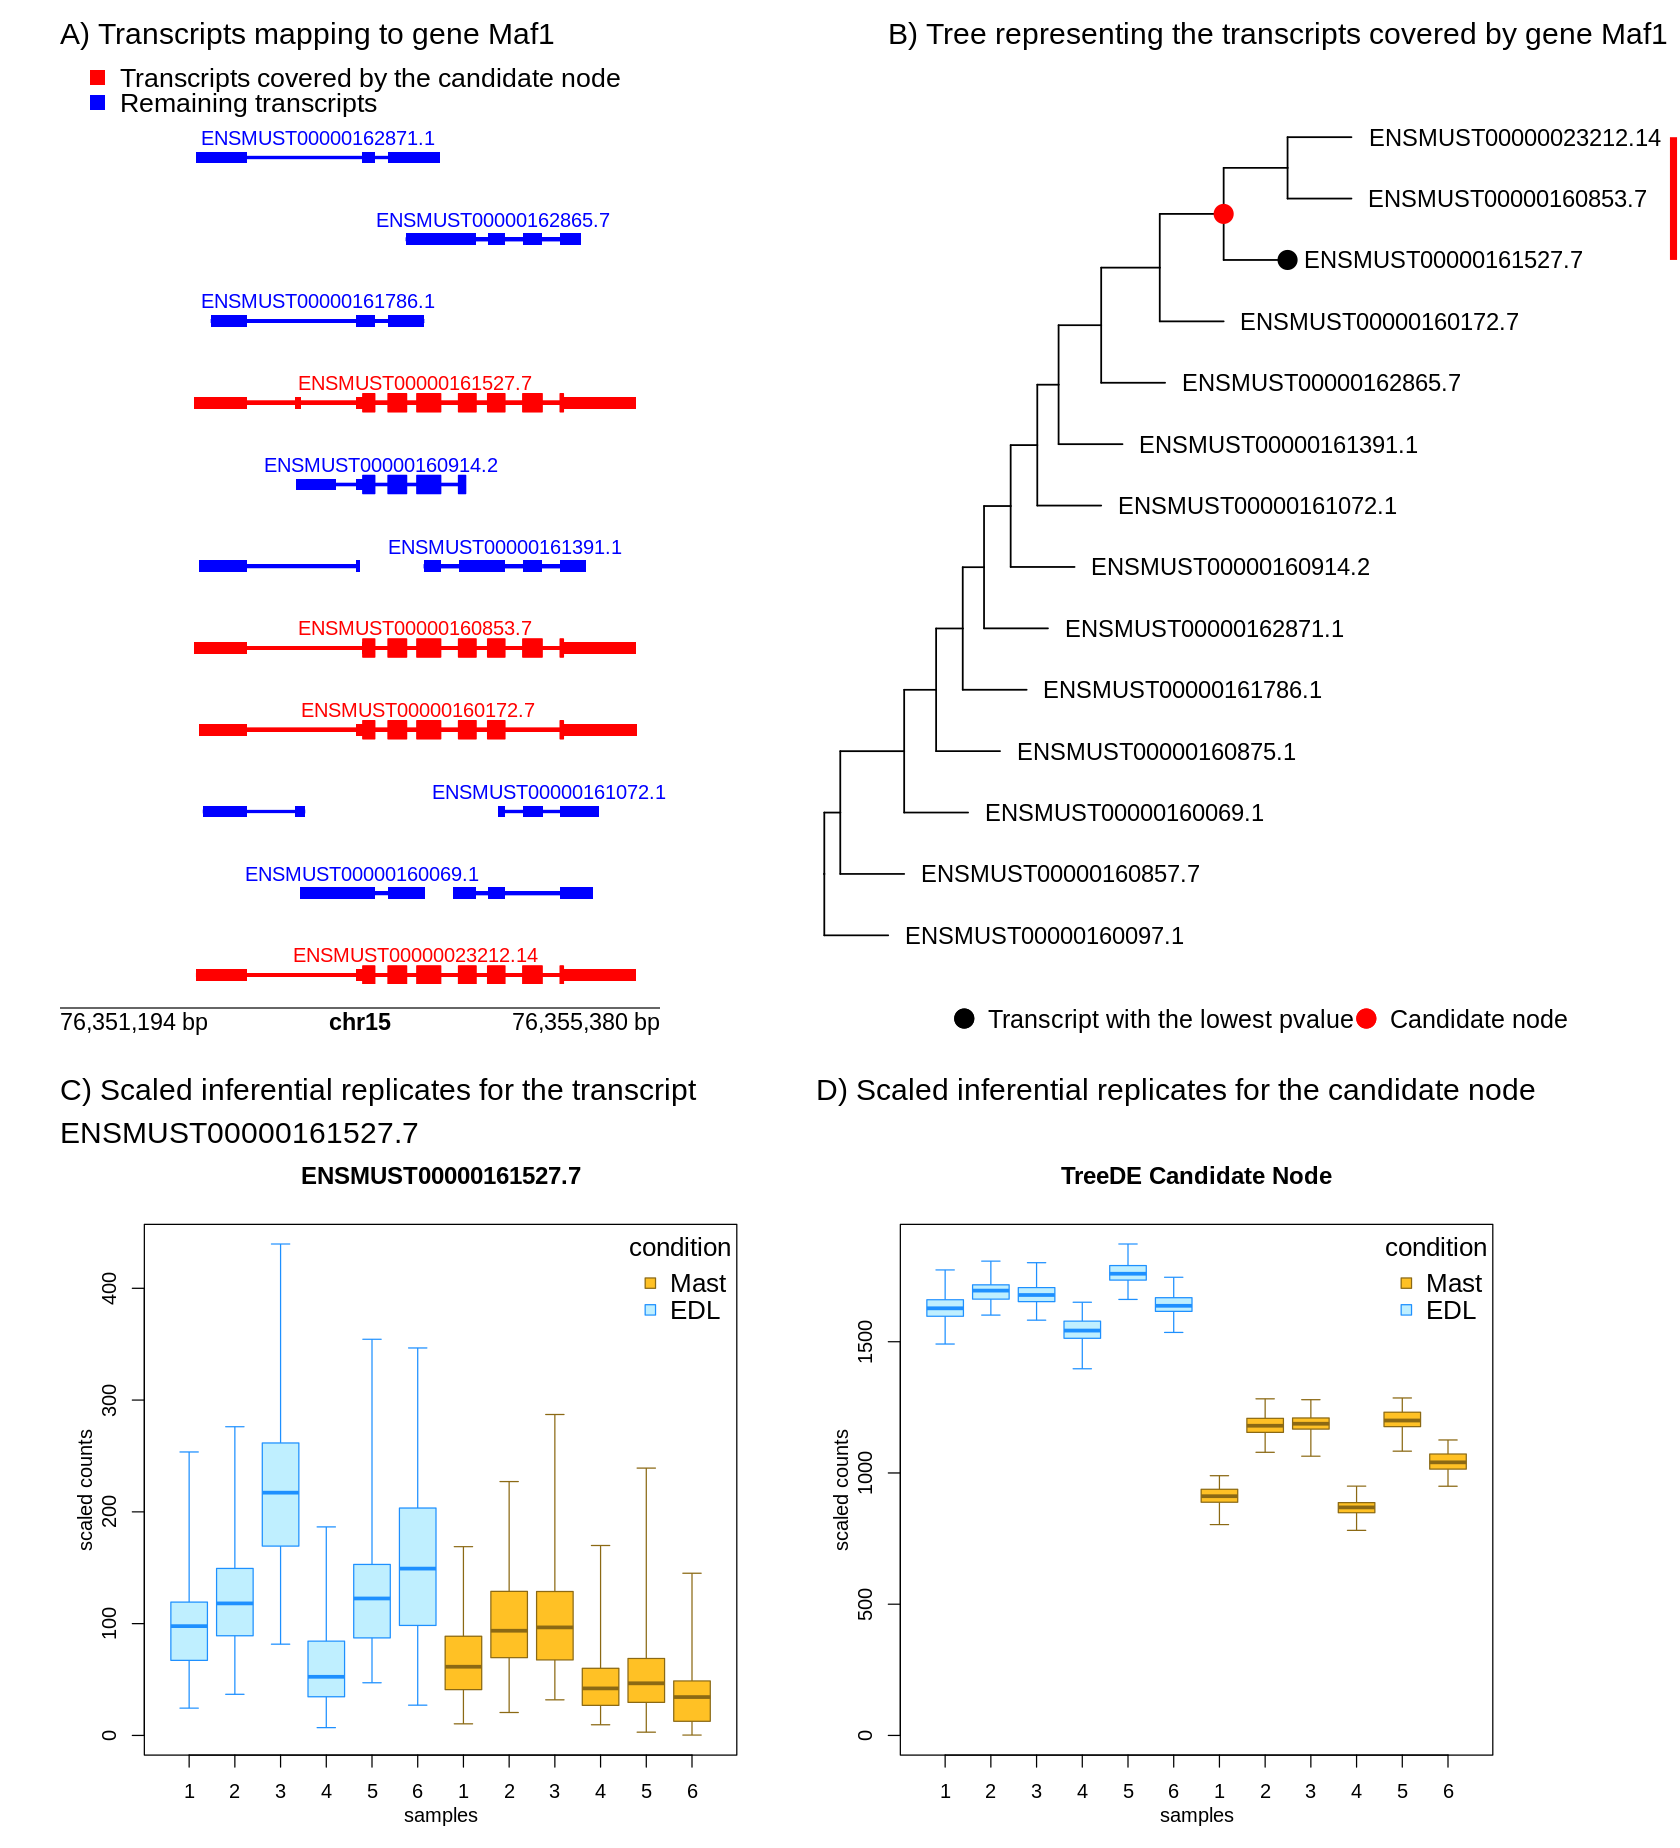

In [95]:
options(repr.plot.width=14, repr.plot.height=15.4)
library(plotgardener)
pageCreate(width = 14, height = 15.4, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-100, chromend = g[["end"]]+1000,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=12
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Maf1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 8.2, width = 5, height = 8.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 8.4, length=5,
  just = c("left", "top"), fontsize=14
)

plotText(label="B) Tree representing the transcripts covered by gene Maf1", 
         x = 7.4, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.4, y =0.76, width = 8, height=8
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000161527.7", 
         x = 0.5, y = 9, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 9.5, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 6.8, y = 9, params = parText)

plotGG(
    plot = pInn,
    x = 6.8, y = 9.5, width = 6, height=6
)


In [81]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 95
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000085116.3" "ENSMUST00000170188.7" "ENSMUST00000221148.1"
[4] "ENSMUST00000223321.1" "ENSMUST00000221535.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000021009.15"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr12,98676741,98737405,60665,-,24000,ENSMUSG00000021009


ENSMUSG00000021009.15  ENSMUSG00000021009.15  ENSMUSG00000021009.15 
"ENSMUST00000170188.7" "ENSMUST00000223321.1" "ENSMUST00000085116.3" 
 ENSMUSG00000021009.15  ENSMUSG00000021009.15  ENSMUSG00000021009.15 
"ENSMUST00000221148.1" "ENSMUST00000221535.1" "ENSMUST00000221932.1" 
 ENSMUSG00000021009.15 
"ENSMUST00000222071.1"

[1] 3

[1] TRUE

In [82]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 10
lNode <- 3
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



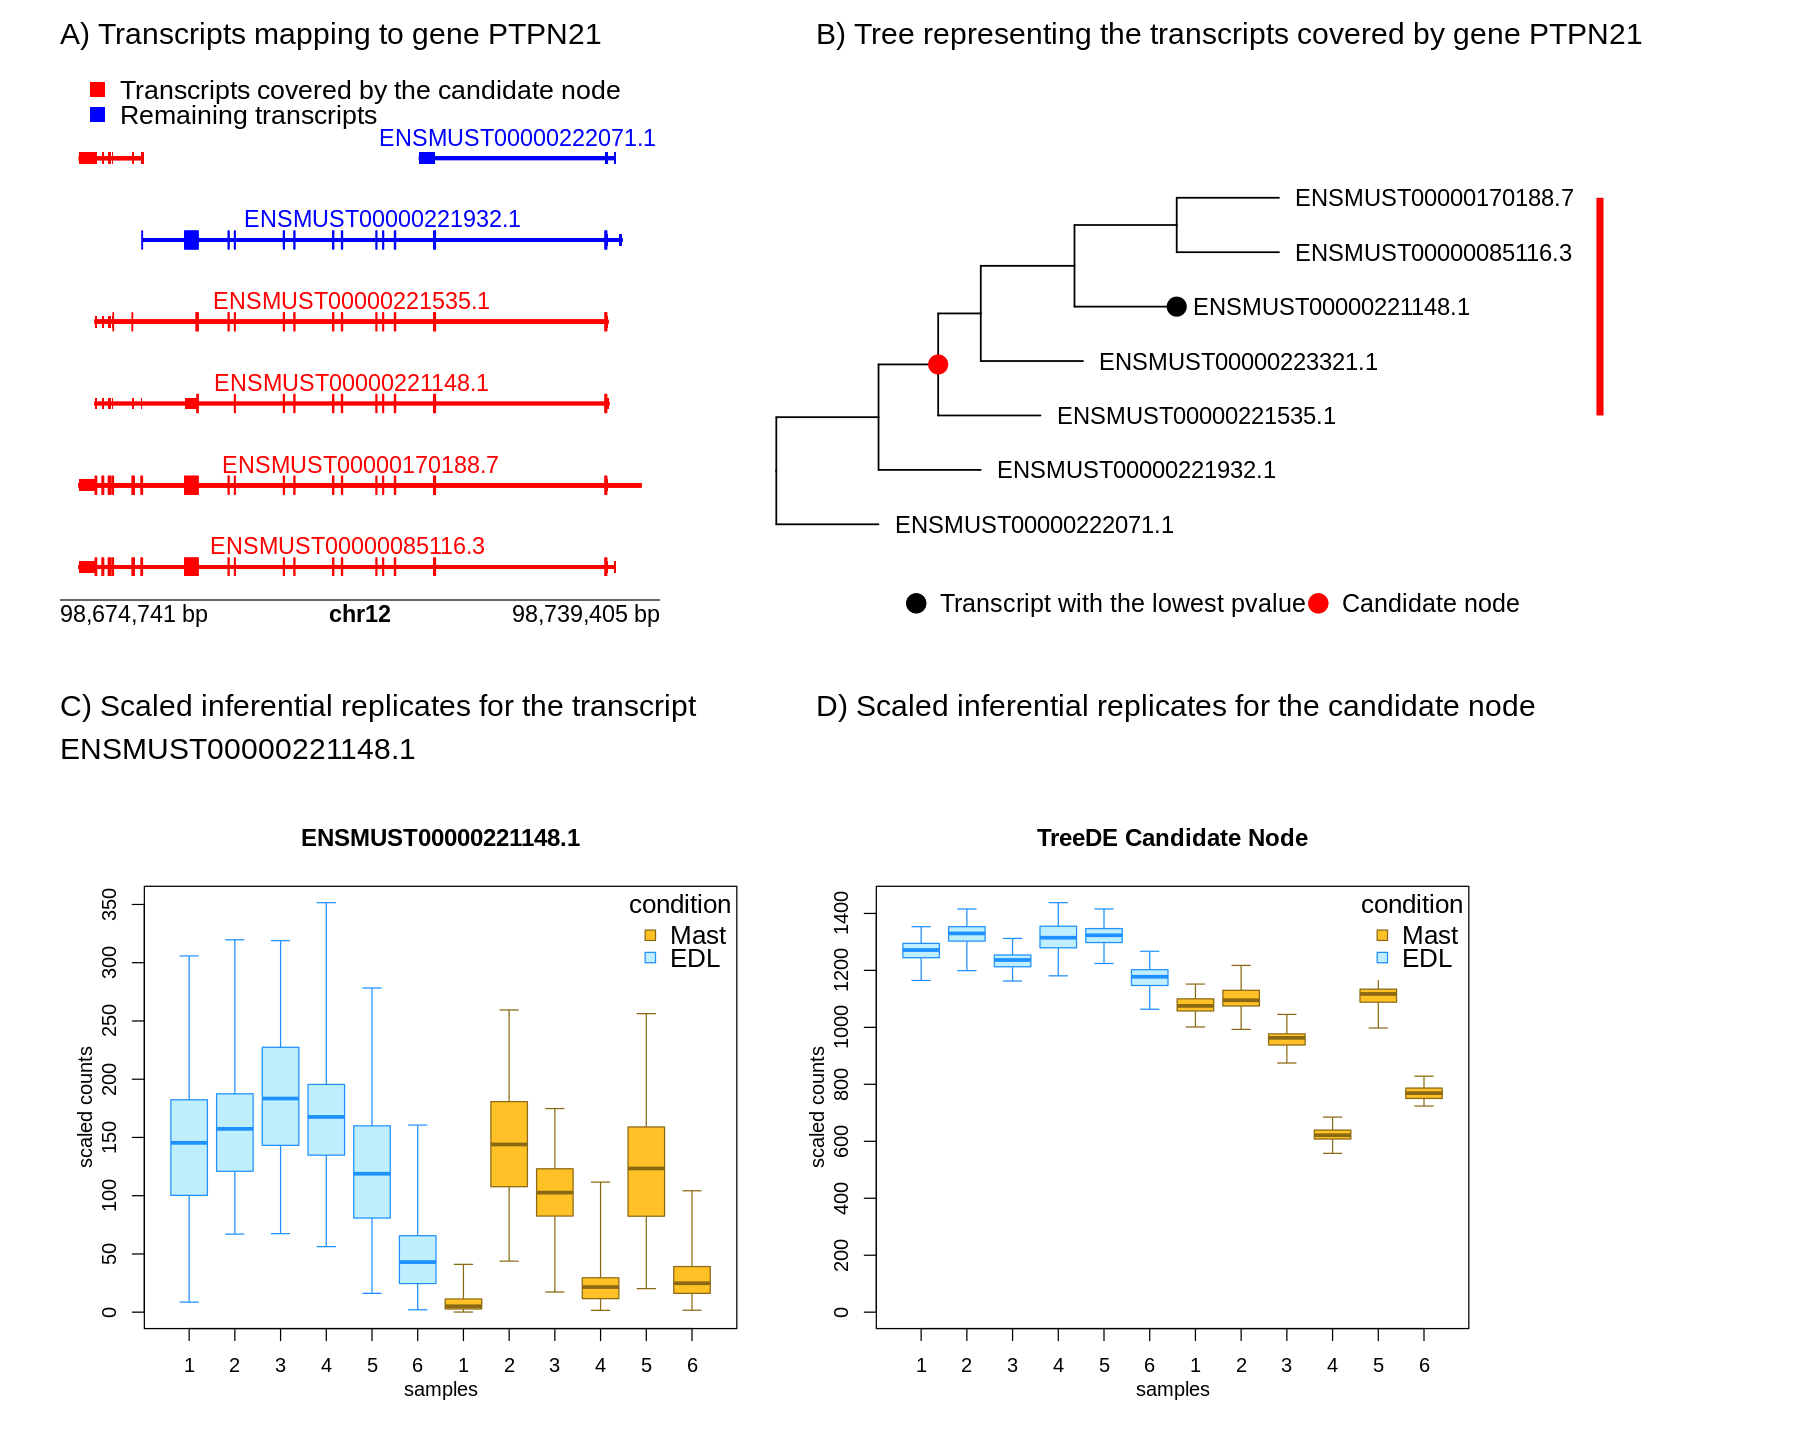

In [83]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]]+2000,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene PTPN21", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.8, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene PTPN21", 
         x = 6.8, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000221148.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 6.8, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 6.6, y = 6.8, width = 6, height=5
)


In [61]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 451
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000118810.1" "ENSMUST00000075667.4" "ENSMUST00000119664.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000041775.7"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr7,138835823,138846273,10451,-,69546,ENSMUSG00000041775


ENSMUSG00000041775.7   ENSMUSG00000041775.7   ENSMUSG00000041775.7 
"ENSMUST00000119664.1" "ENSMUST00000075667.4" "ENSMUST00000118810.1"

[1] 2

[1] TRUE

In [62]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 4
lNode <- 2
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



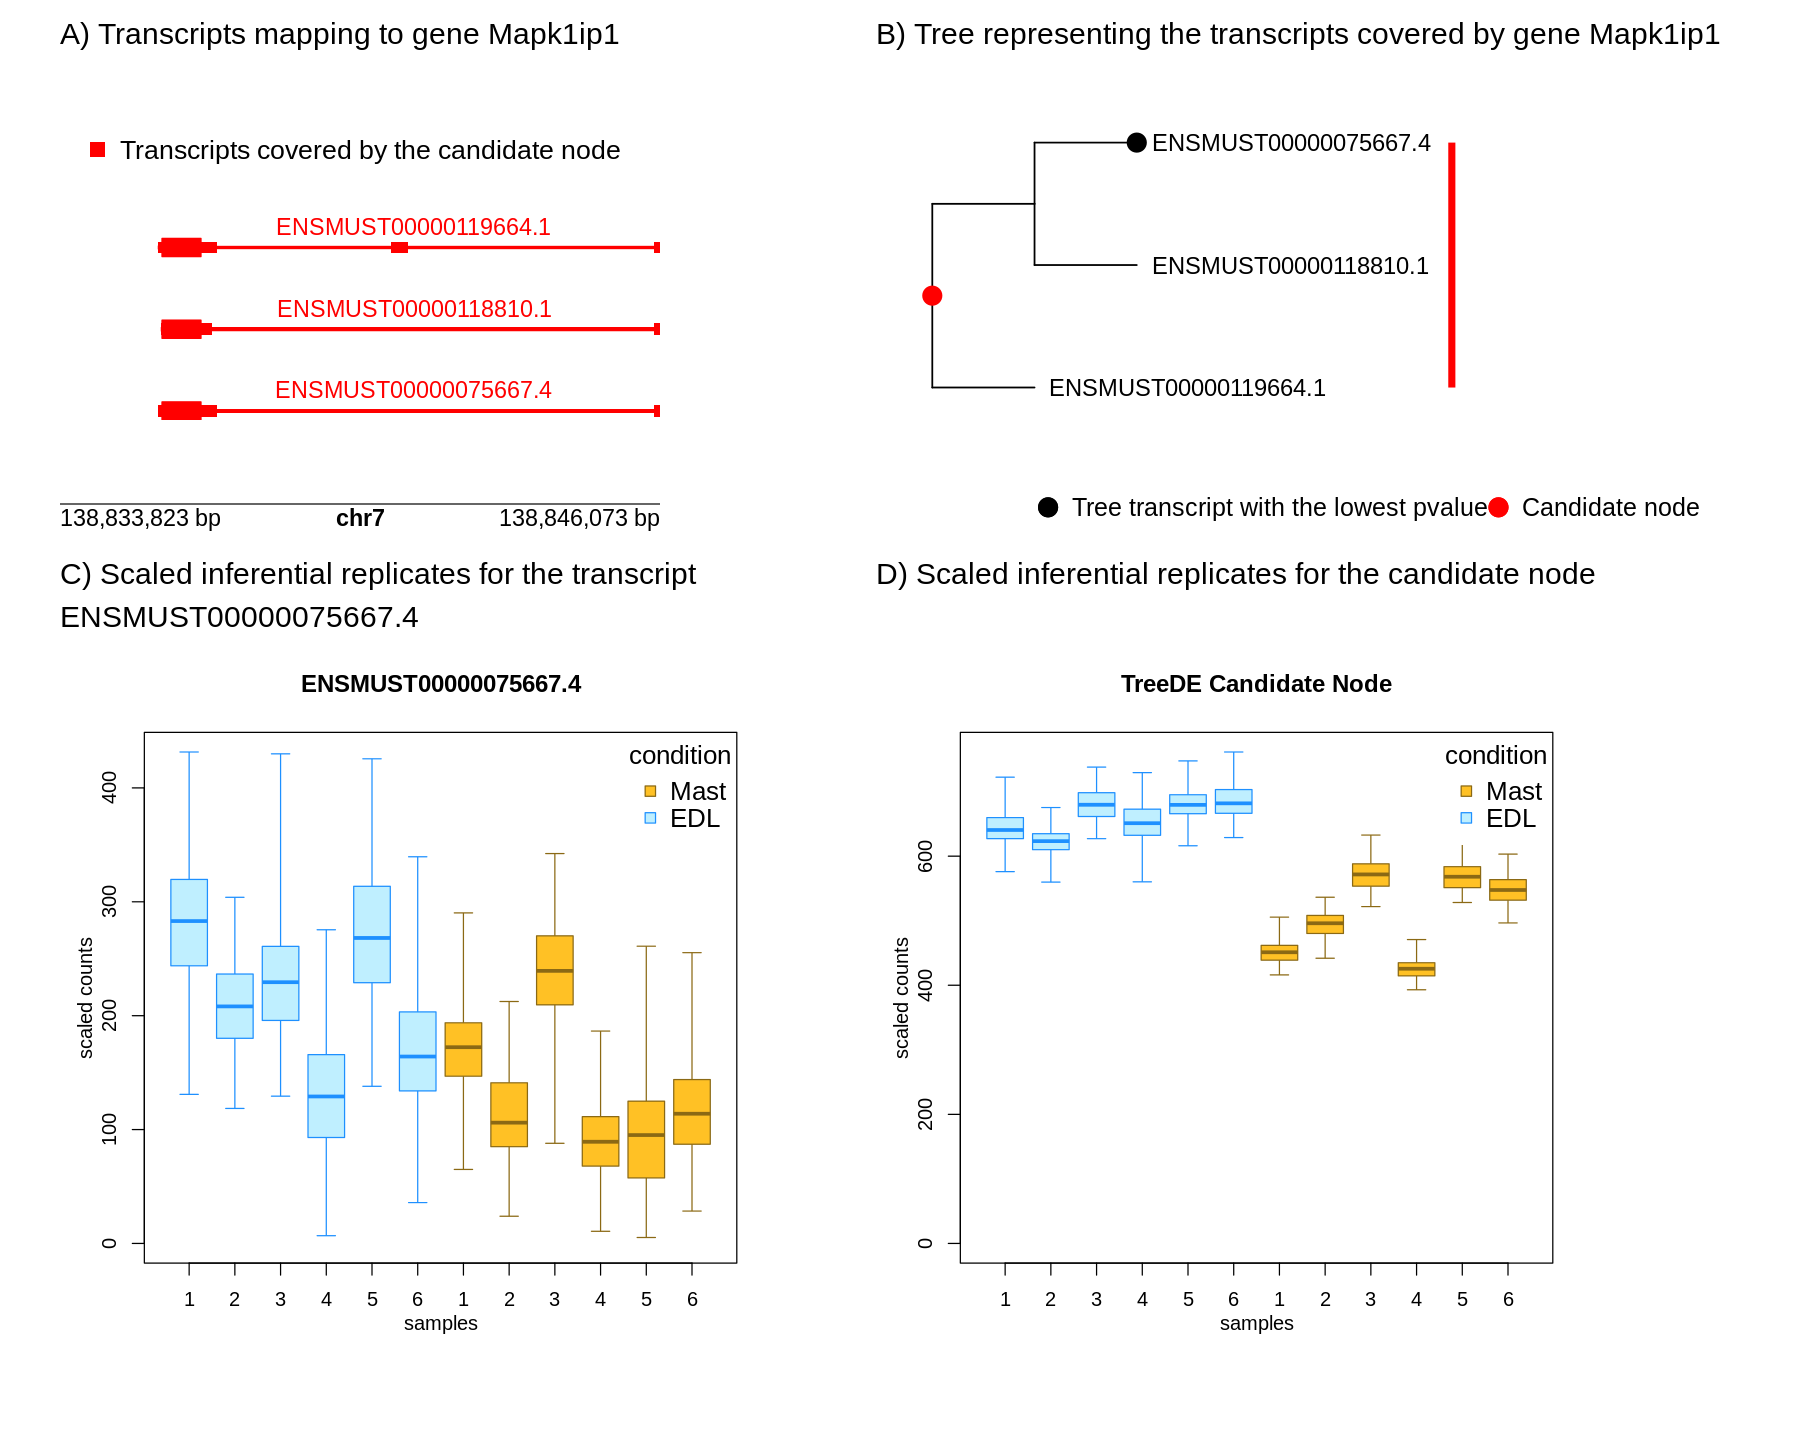

In [79]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]]-200,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node"),
    fill = c("red"), border = FALSE,
    x = 0.5, y = 1, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Mapk1ip1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 3.5, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.2, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Mapk1ip1", 
         x = 7.3, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 7.3, y = 0.5, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000075667.4", 
         x = 0.5, y = 4.7, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 5.4, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.3, y = 4.7, params = parText)

plotGG(
    plot = pInn,
    x = 7.3, y = 5.4, width = 6, height=6
)


In [58]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 49
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000093360.11" "ENSMUST00000166592.1"  "ENSMUST00000210576.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000031691.14"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr8,85036915,85057583,20669,+,212999,ENSMUSG00000031691


ENSMUSG00000031691.14   ENSMUSG00000031691.14   ENSMUSG00000031691.14 
"ENSMUST00000093360.11"  "ENSMUST00000211601.1"  "ENSMUST00000166592.1" 
  ENSMUSG00000031691.14   ENSMUSG00000031691.14   ENSMUSG00000031691.14 
 "ENSMUST00000210945.1"  "ENSMUST00000210576.1"  "ENSMUST00000210117.1" 
  ENSMUSG00000031691.14 
 "ENSMUST00000210461.1"

[1] 2

[1] TRUE

In [59]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 12
lNode <- 2
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



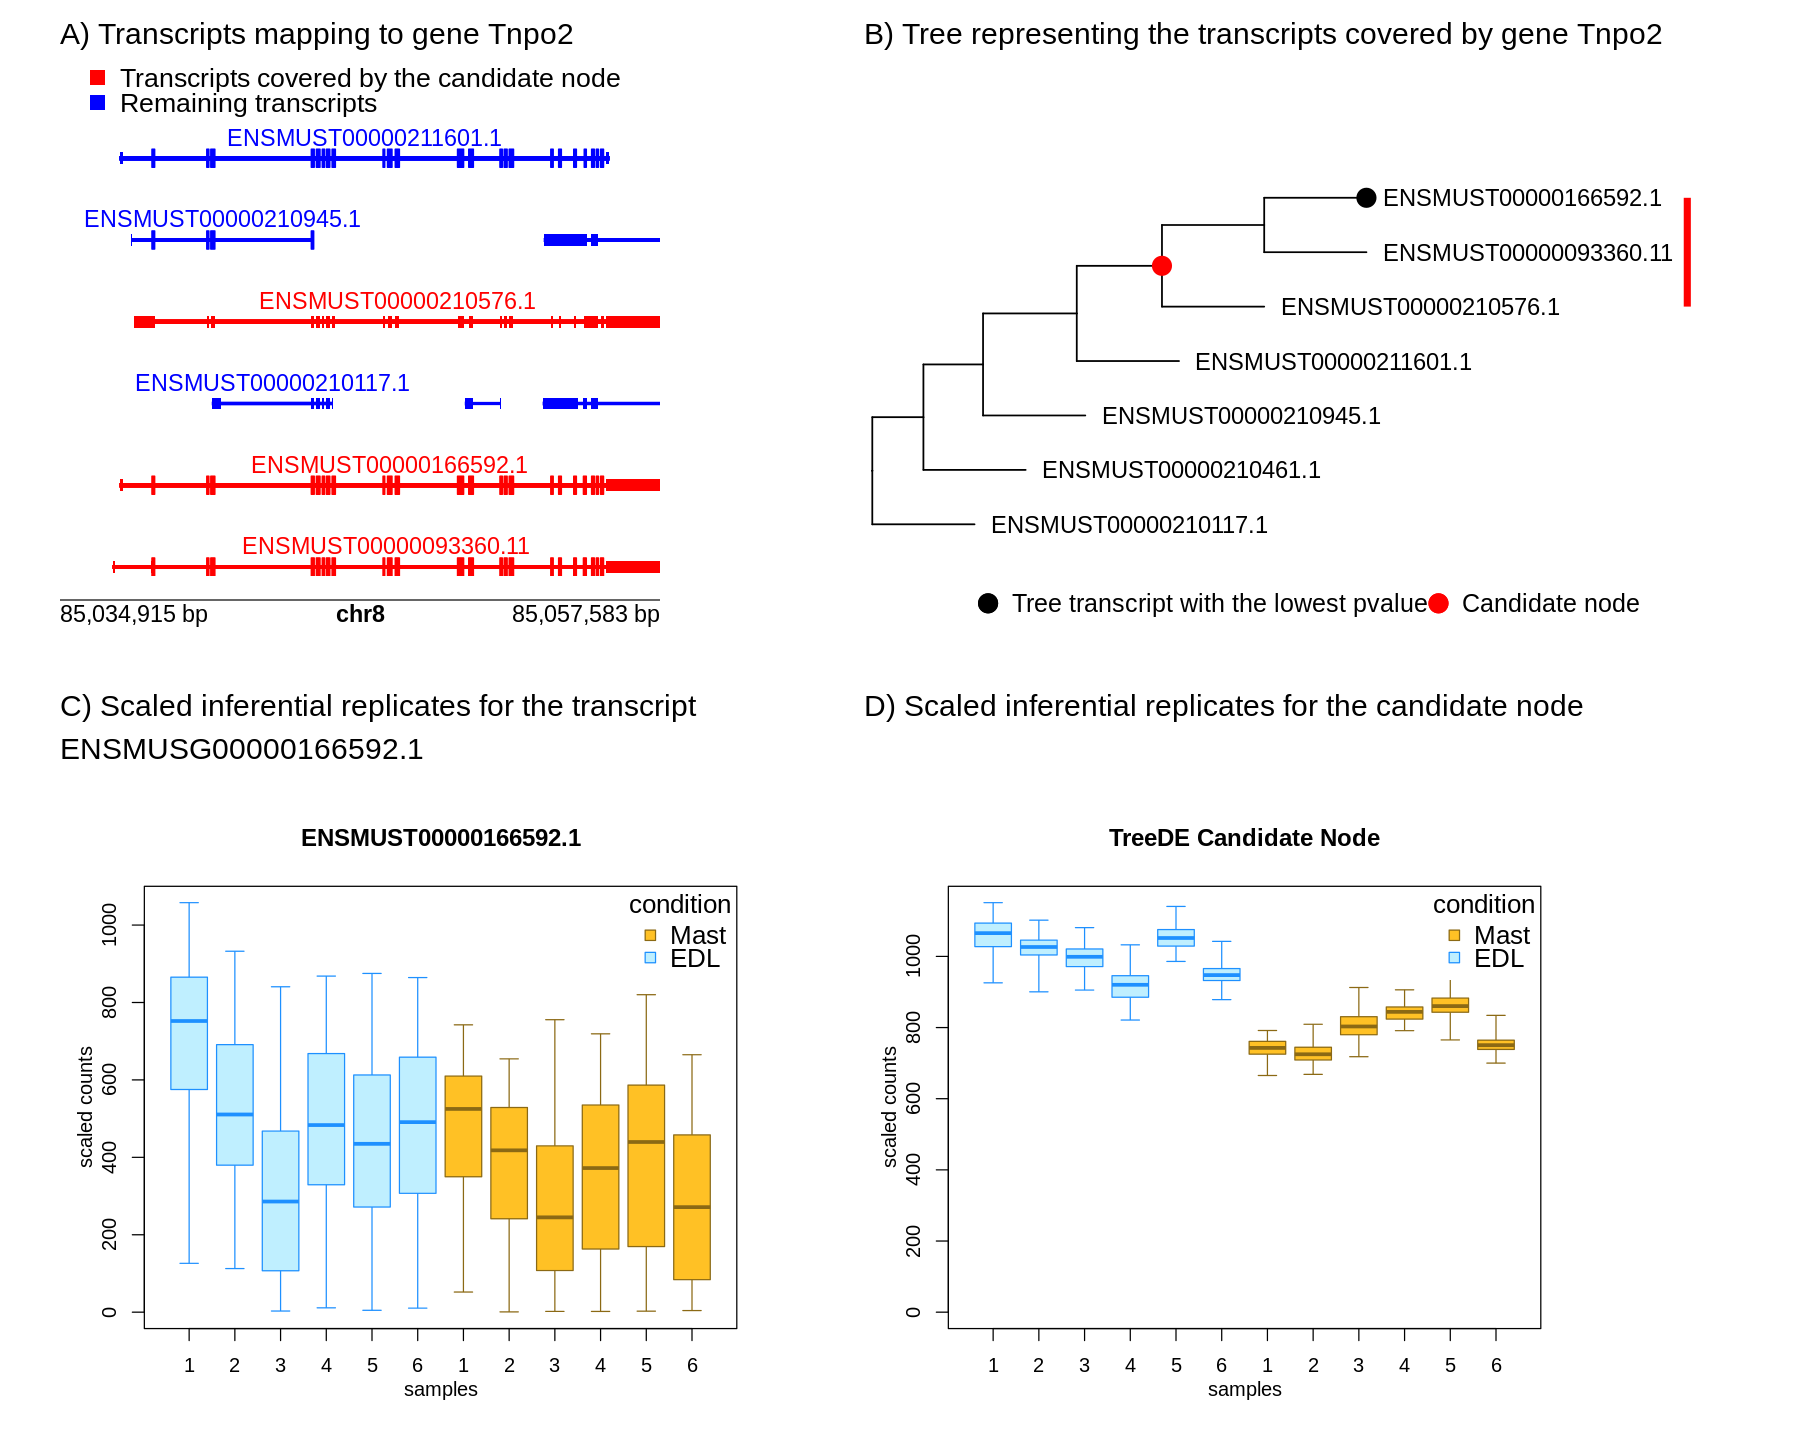

In [60]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Tnpo2", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.8, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Tnpo2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUSG00000166592.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [50]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 312
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000114516.7" "ENSMUST00000121869.7" "ENSMUST00000147358.7"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000064061.13"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr16,48924232,48994165,69934,-,224170,ENSMUSG00000064061


ENSMUSG00000064061.13  ENSMUSG00000064061.13  ENSMUSG00000064061.13 
"ENSMUST00000147358.7" "ENSMUST00000121869.7" "ENSMUST00000139350.7" 
 ENSMUSG00000064061.13  ENSMUSG00000064061.13  ENSMUSG00000064061.13 
"ENSMUST00000114516.7" "ENSMUST00000151950.1" "ENSMUST00000123961.1" 
 ENSMUSG00000064061.13 
"ENSMUST00000133377.1"

[1] 1

[1] TRUE

In [51]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 11
lNode <- 1
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



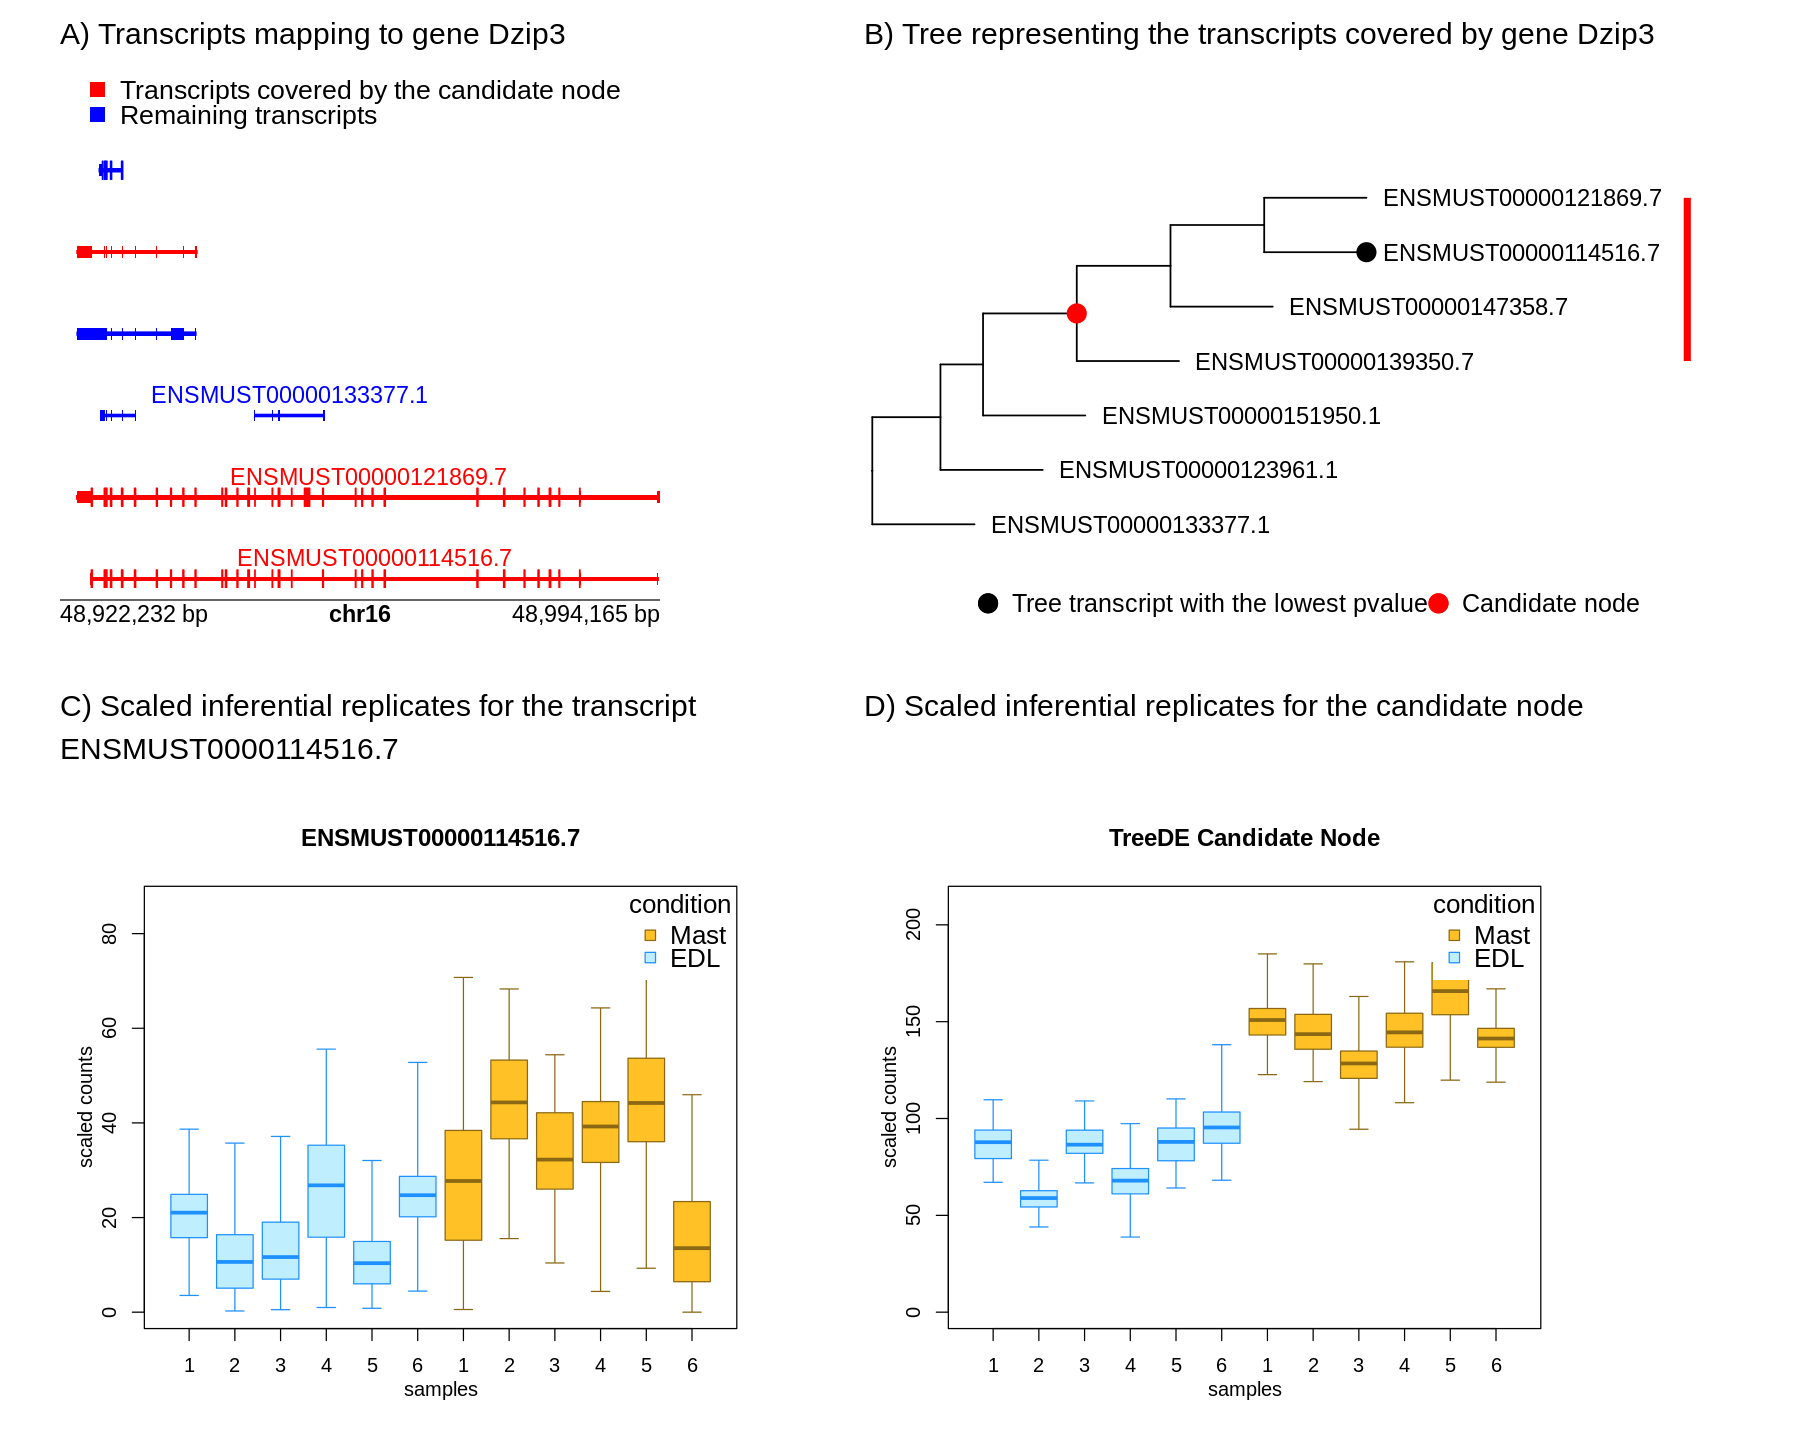

In [54]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Dzip3", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.9, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Dzip3", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000114516.7", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [48]:
j <- 150
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000025826.6" "ENSMUST00000237371.1" "ENSMUST00000236152.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000024891.6"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,5023860,5031972,8113,+,13340,ENSMUSG00000024891


ENSMUSG00000024891.6   ENSMUSG00000024891.6   ENSMUSG00000024891.6 
"ENSMUST00000236152.1" "ENSMUST00000025826.6" "ENSMUST00000237371.1" 
  ENSMUSG00000024891.6   ENSMUSG00000024891.6   ENSMUSG00000024891.6 
"ENSMUST00000235416.1" "ENSMUST00000235933.1" "ENSMUST00000237267.1"

[1] 2

[1] TRUE

In [49]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 10
lNode <- 2
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



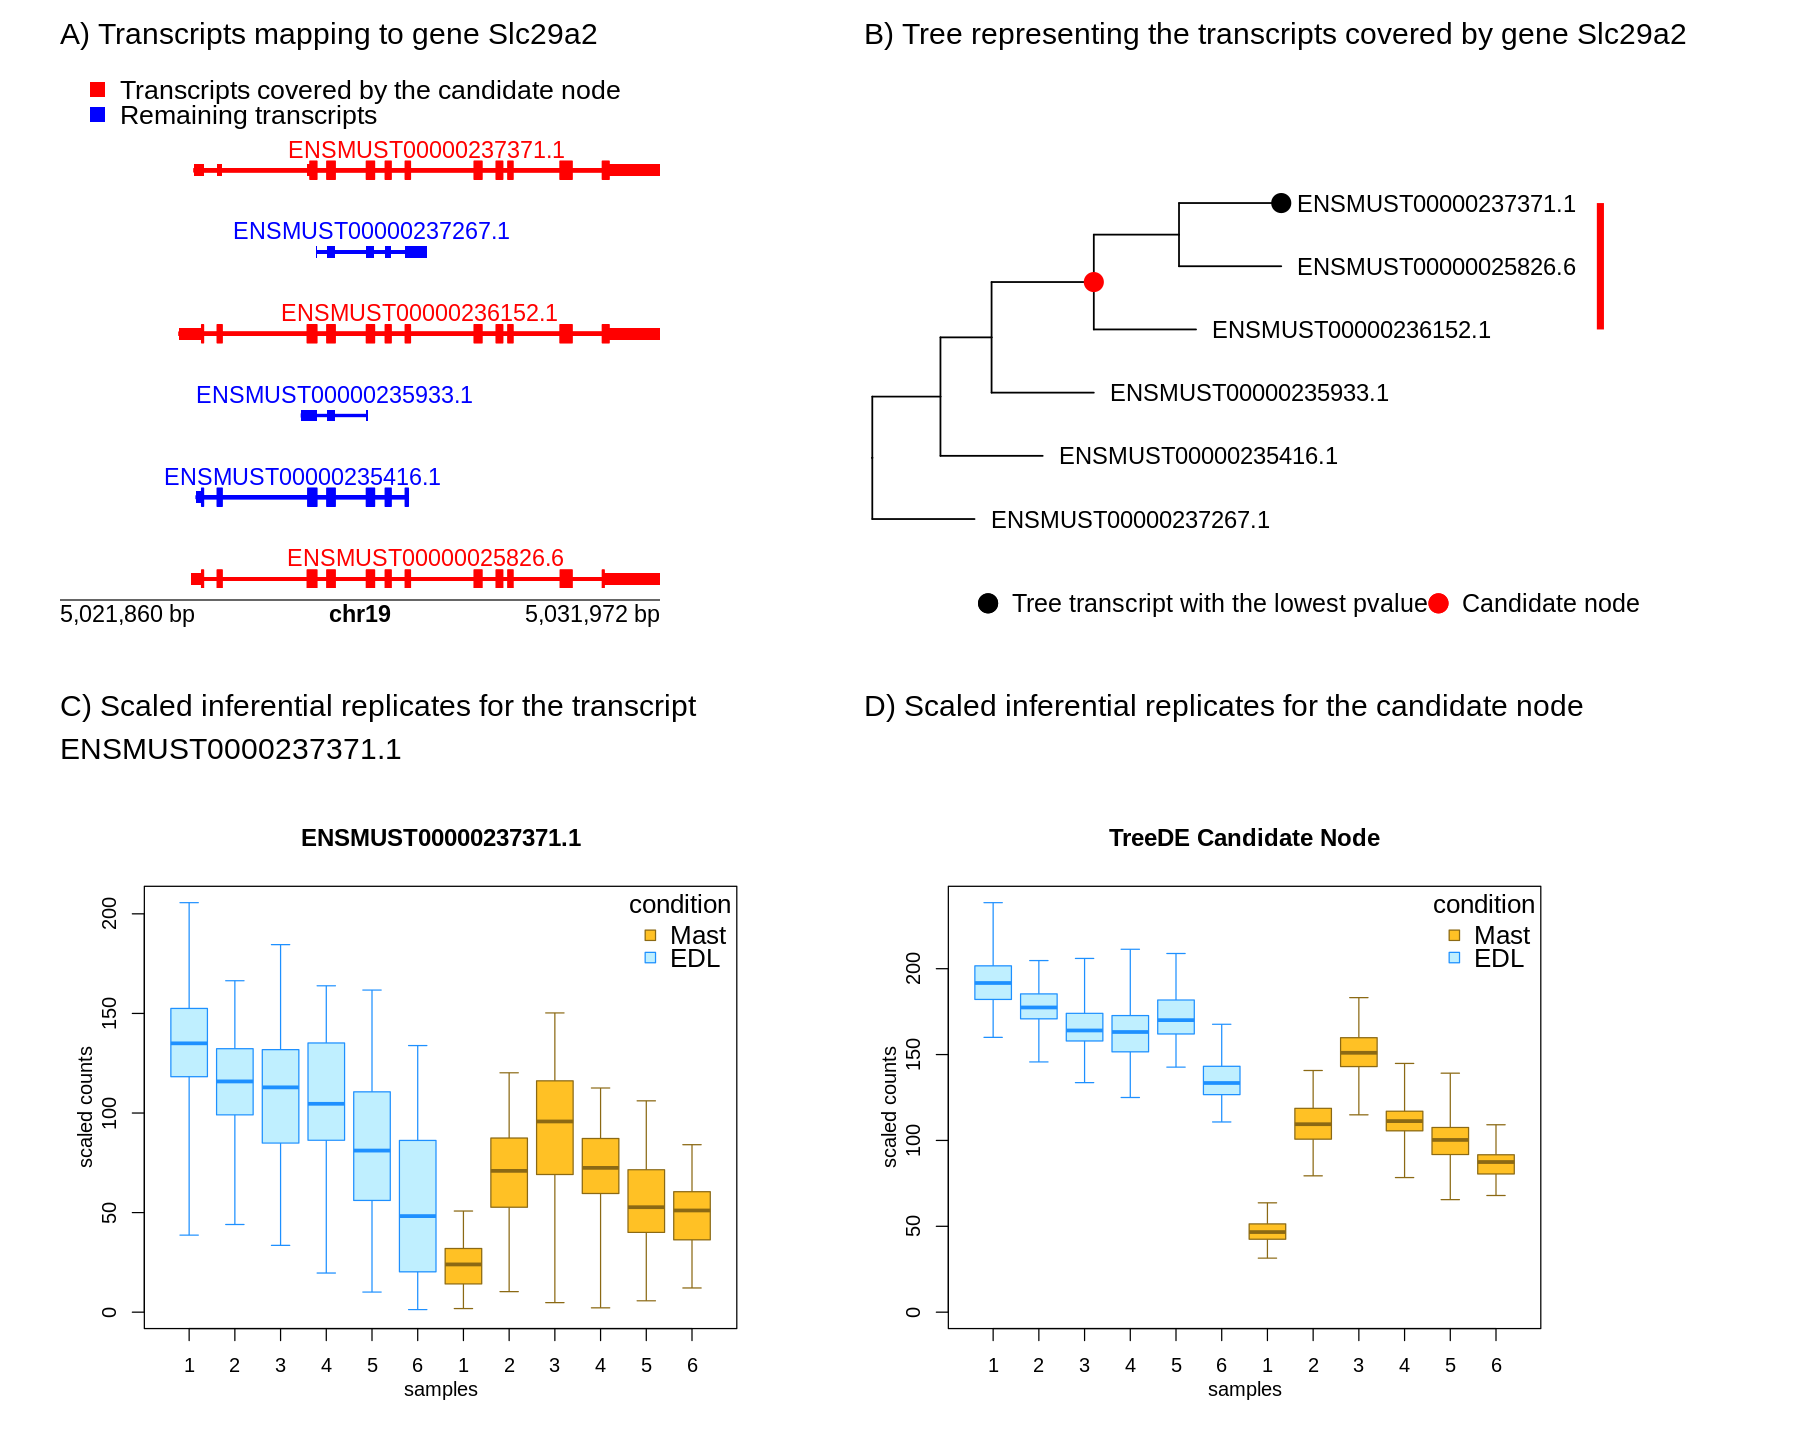

In [47]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Slc29a2", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.9, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Slc29a2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000237371.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [29]:
j <- 385
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000235927.1" "ENSMUST00000087951.6" "ENSMUST00000237240.1"
[4] "ENSMUST00000235921.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000048832.9"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,10688735,10714627,25893,+,107305,ENSMUSG00000048832


ENSMUSG00000048832.9   ENSMUSG00000048832.9   ENSMUSG00000048832.9 
"ENSMUST00000237240.1" "ENSMUST00000087951.6" "ENSMUST00000235927.1" 
  ENSMUSG00000048832.9   ENSMUSG00000048832.9 
"ENSMUST00000237437.1" "ENSMUST00000235921.1"

[1] 3

[1] TRUE

In [30]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 7
lNode <- 3
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))

text[text1]

legend[legend1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



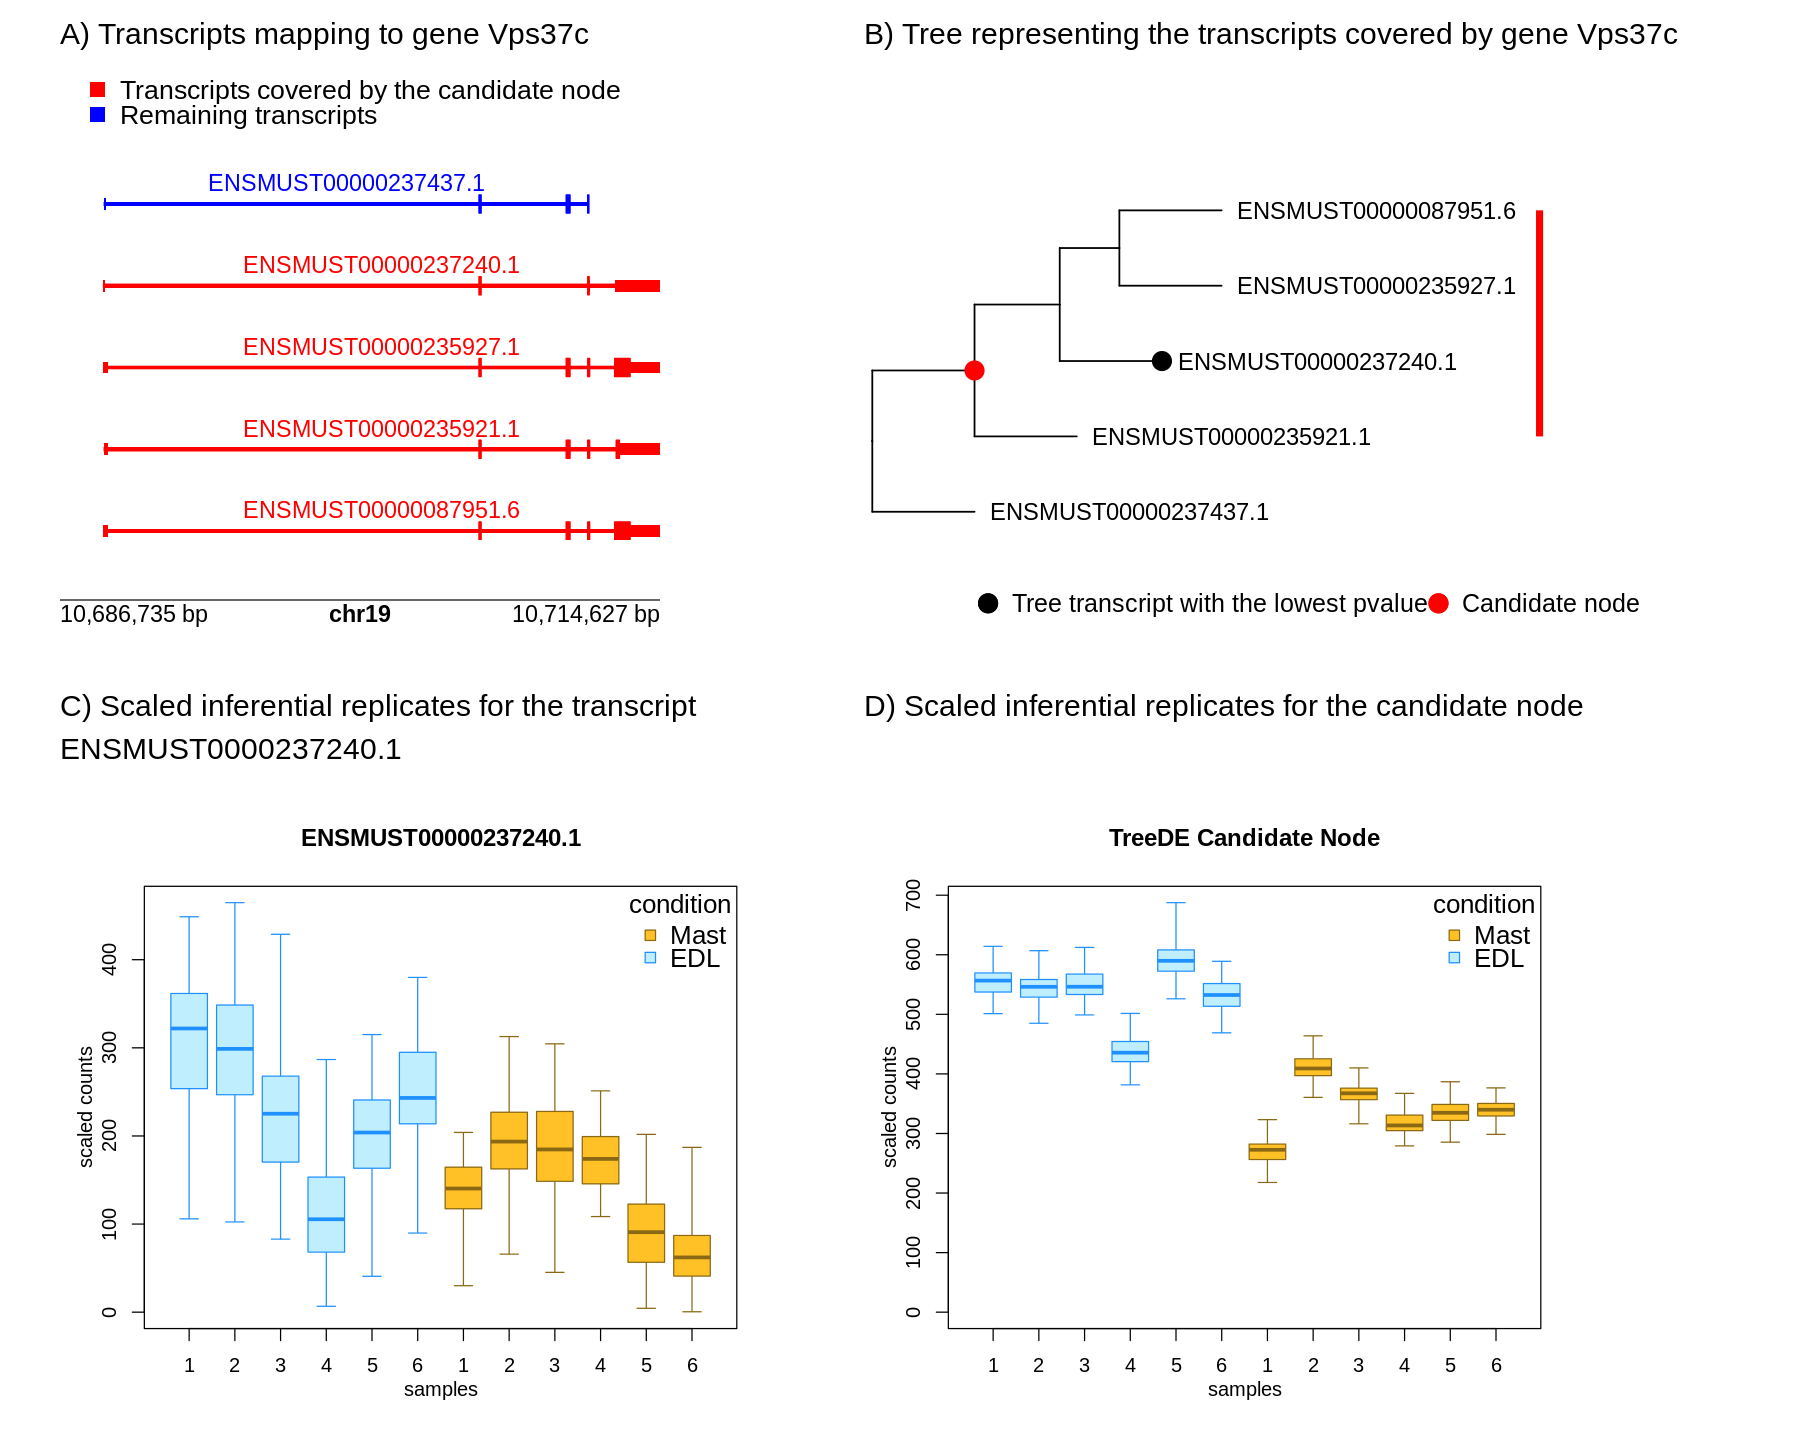

In [37]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotText(label="A) Transcripts mapping to gene Vps37c", x = 0.5, y = 0.2,
        params = parText)
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotTranscripts(
    params = par, x = 0.5, y = 4.5, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Vps37c", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000237240.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [108]:
j <- 14
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000040729.8" "ENSMUST00000160961.7" "ENSMUST00000233633.1"
[4] "ENSMUST00000162862.2"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000036636.10"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr17,25133391,25162104,28714,+,26373,ENSMUSG00000036636


ENSMUSG00000036636.10  ENSMUSG00000036636.10  ENSMUSG00000036636.10 
"ENSMUST00000162862.2" "ENSMUST00000040729.8" "ENSMUST00000233633.1" 
 ENSMUSG00000036636.10  ENSMUSG00000036636.10  ENSMUSG00000036636.10 
"ENSMUST00000162722.1" "ENSMUST00000160961.7" "ENSMUST00000159773.1" 
 ENSMUSG00000036636.10 
"ENSMUST00000159426.1"

[1] 2

[1] TRUE

In [117]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 11
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))

text[text1]

legend[legend1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



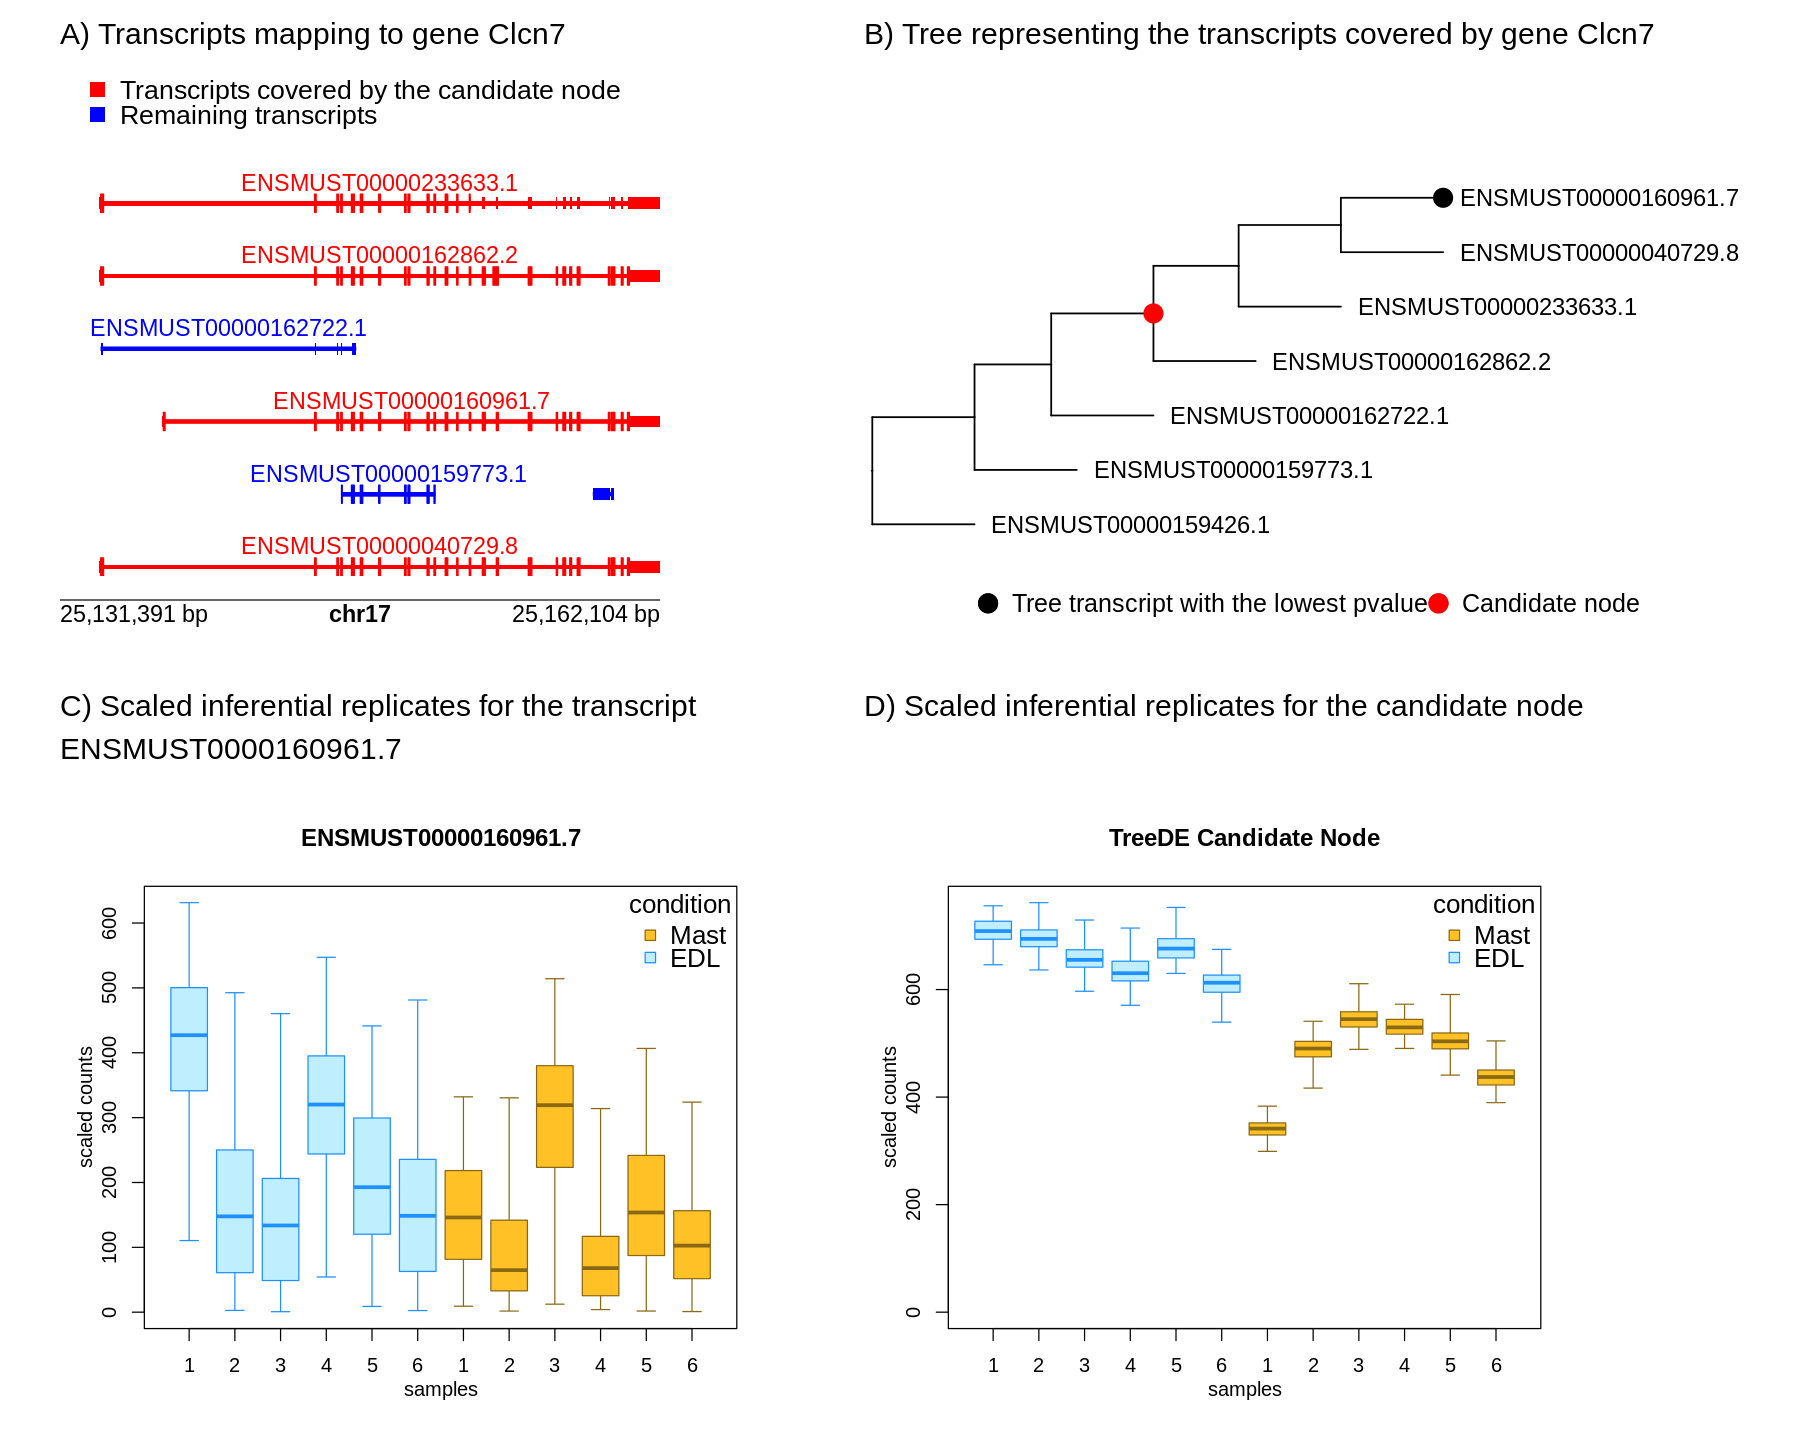

In [119]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotText(label="A) Transcripts mapping to gene Clcn7", x = 0.5, y = 0.2,
        params = parText)
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotTranscripts(
    params = par, x = 0.5, y = 4.8, width = 5, height = 5.5, 
    spaceHeight=2.0, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Clcn7", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000160961.7", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [124]:
j <- 79
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000096194.8" "ENSMUST00000025663.7"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000024754.13"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,21778342,21858360,80019,+,83921,ENSMUSG00000024754


ENSMUSG00000024754.13  ENSMUSG00000024754.13  ENSMUSG00000024754.13 
"ENSMUST00000096194.8" "ENSMUST00000236506.1" "ENSMUST00000025663.7" 
 ENSMUSG00000024754.13  ENSMUSG00000024754.13 
"ENSMUST00000237802.1" "ENSMUST00000238079.1"

[1] 2

[1] TRUE

In [125]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 8
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))

text[text1]

legend[legend1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



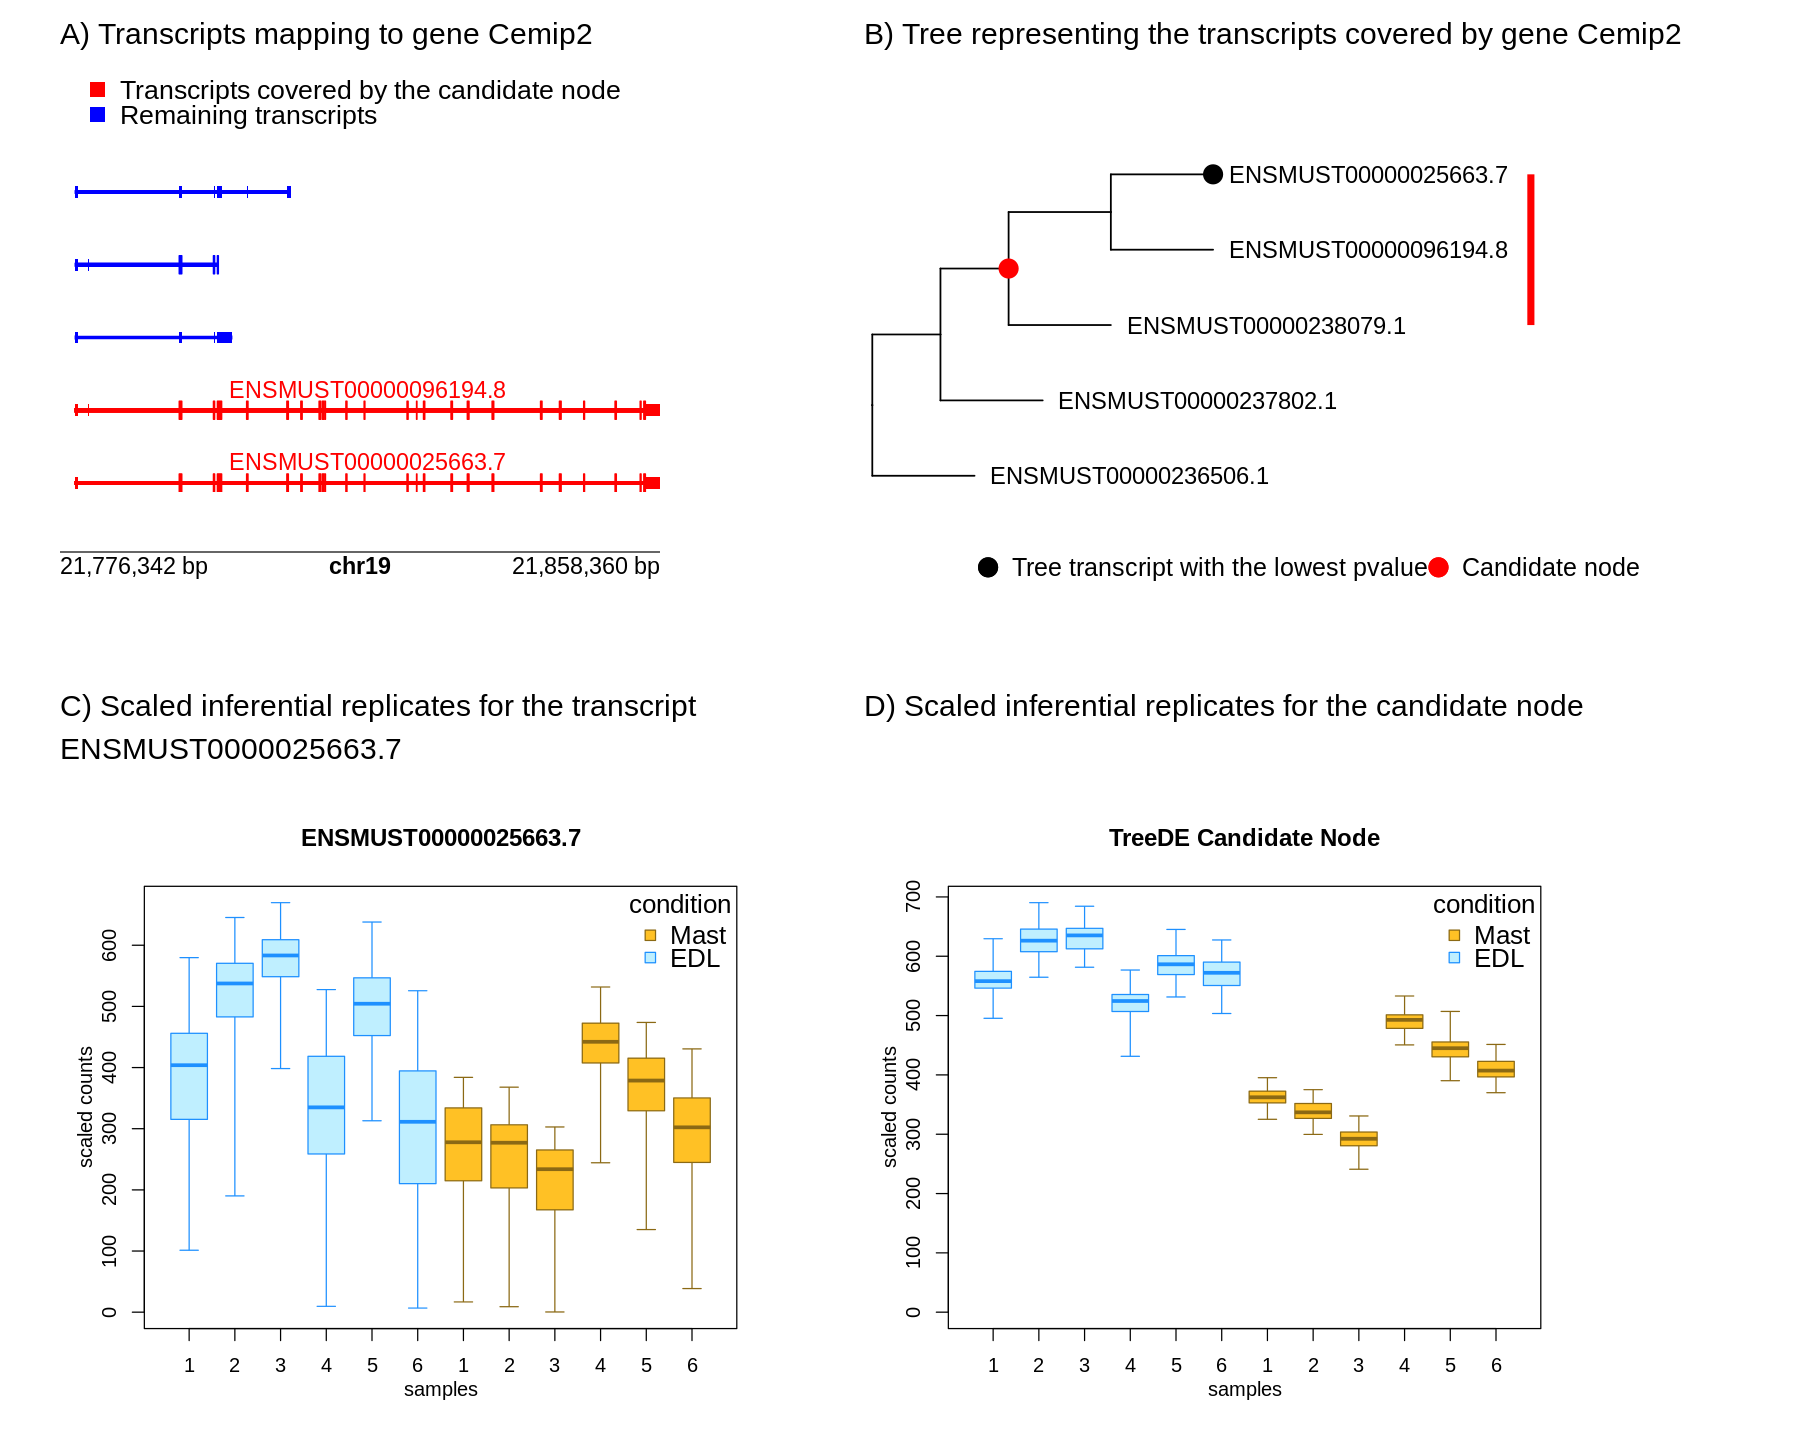

In [129]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotText(label="A) Transcripts mapping to gene Cemip2", x = 0.5, y = 0.2,
        params = parText)
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotTranscripts(
    params = par, x = 0.5, y = 4.1, width = 5, height = 5.5, 
    spaceHeight=2.0, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.6, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Cemip2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000025663.7", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)